In [1]:
##collect rs-fMRI signals
from pathlib import Path
pathroot=Path('/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/')
subject = '100206'
modality = 'REST' #'MOTOR'

pathdata = pathroot
pathout = '/home/yuzhang/projects/rrg-pbellec/yuzhang/HCP/'
print(pathdata)

import os
import glob
fmri_files = [];
confound_files = [];
WM_files = [];
CSF_files = [];
subjects = []
for fmri_file in sorted(pathdata.glob('*/FMRI/rfMRI_'+modality+'*/rfMRI_'+modality+'*_Atlas_hp2000_clean.dtseries.nii')):
    subjects.append(Path(os.path.dirname(fmri_file)).parts[-3])
    fmri_files.append(str(fmri_file))
    
for confound in sorted(pathdata.glob('*/FMRI/rfMRI_'+modality+'*/Movement_Regressors.txt')):
    confound_files.append(str(confound))
    
for file in sorted(pathdata.glob('*/FMRI/rfMRI_'+modality+'*/rfMRI_'+modality+'*_WM.txt')):
    WM_files.append(str(file))
    
for file in sorted(pathdata.glob('*/FMRI/rfMRI_'+modality+'*/rfMRI_'+modality+'*_CSF.txt')):
    CSF_files.append(str(file))
    
print('%d subjects included in the dataset' % len(fmri_files))
print(len(confound_files), len(WM_files), len(CSF_files))
#print(fmri_files)
print(subjects)

/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718
4233 subjects included in the dataset
4233 4233 4233
['100206', '100206', '100206', '100206', '100307', '100307', '100307', '100307', '100408', '100408', '100408', '100408', '100610', '100610', '100610', '100610', '101006', '101006', '101006', '101006', '101107', '101107', '101107', '101107', '101309', '101309', '101309', '101309', '101410', '101410', '101915', '101915', '101915', '101915', '102008', '102008', '102008', '102008', '102109', '102109', '102109', '102109', '102311', '102311', '102311', '102311', '102513', '102513', '102513', '102513', '102614', '102614', '102614', '102614', '102715', '102715', '102715', '102715', '102816', '102816', '102816', '102816', '103010', '103010', '103010', '103010', '103111', '103111', '103111', '103111', '103212', '103212', '103212', '103212', '103414', '103414', '103414', '103414', '103515', '103515', '103515', '103515', '103818', '103818', '103818', '103818', '104012', '104012', '10

In [12]:
import numpy as np
import pandas as pd
sub_name = np.unique(subjects)[:100]
#print(sub_name)
print(fmri_files[1:10])

condition_mask = np.nonzero(pd.Series(subjects).isin(np.unique(sub_name)))[0]
#condition_mask = np.array(pd.Series(subjects).isin(sub_name))
print(condition_mask.shape)
fmri_files = [fmri_files[ii] for ii in condition_mask] #fmri_files[condition_mask]
confound_files = [confound_files[ii] for ii in condition_mask] #confound_files[condition_mask]
WM_files = [WM_files[ii] for ii in condition_mask] #WM_files[condition_mask]
CSF_files = [CSF_files[ii] for ii in condition_mask] #CSF_files[condition_mask]
print(len(fmri_files))

['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100206/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii', '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100206/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii', '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100206/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii', '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii', '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii', '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii', '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii', '/home/yuzhang/proj

In [13]:
from tensorpack.utils import logger
from tensorpack import dataflow
from tensorpack.utils.utils import get_tqdm
from tensorpack.utils.serialize import dumps, loads
import lmdb

####tensorpack: multithread
class dataflow_fmri_with_confound(dataflow.DataFlow):
    """ Iterate through fmri filenames and confound filenames
    """

    def __init__(self, fmri_files, confound_files):
        assert (len(fmri_files) == len(confound_files))
        # self.data=zip(fmri_files,confound_files)
        self.fmri_files = fmri_files
        self.confound_files = confound_files
        self._size = len(fmri_files)

    def size(self):
        return self._size

    def get_data(self):
        if isinstance(self.confound_files, pd.DataFrame):
            for a, b in zip(self.fmri_files, self.confound_files.values):
                yield a, b
        else:
            for a, b in zip(self.fmri_files, self.confound_files):
                yield a, b


def map_surface_to_parcel_fast(atlas_roi, fmri_file):
    ##build a dataframe to extract mean time-series for each roi within each trial

    #atlas_roi = nib.load(parcel_map).get_data()
    RegionLabels = [i for i in np.unique(atlas_roi) if i != 0]
    Region_Num = len(RegionLabels)
    
    try:
        tc = nib.load(str(fmri_file))
    except:
        print("Corrupted nifti file: ", str(fmri_file))
        return None
    tc_matrix = nib.load(str(fmri_file)).get_data()
    if atlas_roi.shape[1] != tc_matrix.shape[1]:
        print("Dimension of parcellation map not matching")
        print("%d vs %d " % (atlas_roi.shape[1], tc_matrix.shape[1]))
        tc_matrix = tc_matrix[:, range(atlas_roi.shape[1])]

    print('Read data from: ', fmri_file)
    Trial_Num, Node_Num = tc_matrix.shape
    tc_matrix_df = pd.DataFrame(data=tc_matrix.ravel(), columns=['tc_signal'])
    tc_matrix_df['roi_label'] = np.repeat(atlas_roi, Trial_Num, axis=0).ravel()
    tc_matrix_df['trial_id'] = np.repeat(np.arange(Trial_Num).reshape((Trial_Num, 1)), Node_Num, axis=1).ravel()
    # df = pd.DataFrame(values, index=index)

    tc_roi = tc_matrix_df.groupby(['roi_label', 'trial_id'], as_index=False).mean()
    tc_roi_matrix = tc_roi['tc_signal'][tc_roi['roi_label'] != 0]
    tc_roi_matrix = tc_roi_matrix.values.reshape(Region_Num, Trial_Num)

    print('Done reading fmri data ', fmri_file)
    # print(np.transpose(np.array(tc_roi_matrix),(1,0)).shape)
    return tc_roi_matrix

def map_func_extract_seris(dp, mmp_atlas_roi):
    fmri_file = dp[0]
    confound_file = dp[1]

    #tc_roi_matrix = map_surface_to_parcel(mmp_atlas_roi, fmri_file)
    tc_roi_matrix = map_surface_to_parcel_fast(mmp_atlas_roi, fmri_file)
    print('Regress out head motion from: ',confound_file)
    tc_matrix = np.transpose(np.array(tc_roi_matrix), (1, 0))
    confound = np.loadtxt(confound_file)
    ##regress out confound effects
    tc_matrix = preprocessing.scale(tc_matrix)
    regr.fit(confound, tc_matrix)
    mist_roi_tc = tc_matrix - np.matmul(confound, regr.coef_.T)

    print('Done regression of confounds ')
    return [fmri_file, mist_roi_tc]

def map_func_extract_resting(dp, mmp_atlas_roi,lowcut=0.01,highcut=0.08,TR=0.72):
    fmri_file = dp[0]
    confound_file = dp[1]
    headmove_file = confound_file[0]
    wm_file = confound_file[1]
    csf_file = confound_file[2]
    #print(len(confound_file),headmove_file,wm_file,csf_file)

    tc_roi_matrix = map_surface_to_parcel_fast(mmp_atlas_roi, fmri_file)
    if tc_roi_matrix is None:
        print("Skip data loading for subject:", fmri_file)
        return [fmri_file, None]
    print('Regress out head motion from: ',confound_file)
    tc_matrix = np.transpose(np.array(tc_roi_matrix), (1, 0))
    from sklearn import preprocessing
    confound_move = np.loadtxt(headmove_file)
    confound_wm = np.expand_dims(preprocessing.scale(np.loadtxt(wm_file)),1)
    confound_csf = np.expand_dims(preprocessing.scale(np.loadtxt(csf_file)),1)
    confound_matrix = np.hstack((confound_move, confound_wm, confound_csf))

    ###step2: regress out confound effects and save the residuals
    from nilearn import signal
    tc_matrix_clean = signal.clean(tc_matrix, detrend=True, standardize=True, confounds=confound_matrix,
                                   low_pass=highcut, high_pass=lowcut, t_r=TR)

    print('Done regression of confounds ')
    return [fmri_file, tc_matrix_clean]


def dump_mean_seris_to_lmdb(df, lmdb_path, write_frequency=10):
    """
    save extracted series into lmdb:lmdb_path
    """
    assert isinstance(df, dataflow.DataFlow), type(df)
    isdir = os.path.isdir(lmdb_path)
    df.reset_state()
    db = lmdb.open(lmdb_path, subdir=isdir,
                   map_size=int(1e12) * 2, readonly=False,
                   meminit=False, map_async=True)  # need sync() at the end
    try:
        sz = df.size()
    except NotImplementedError:
        sz = 0

    with get_tqdm(total=sz) as pbar:
        idx = -1
        keys = []
        txn = db.begin(write=True)
        for idx, dp in enumerate(df.get_data()):
            keystr = u'{}'.format(dp[0]).encode('ascii')
            txn.put(keystr, dumps(dp[1].astype('float32')))  ##change datatype to float32
            #keys += [keystr]
            pbar.update()
            print(idx, keystr)

            if (idx + 1) % write_frequency == 0:
                txn.commit()
                txn = db.begin(write=True)
                # print(idx+1)

        # write last batch
        txn.commit()

        #with db.begin(write=True) as txn:
        #    txn.put(b'__keys__', dumps(keys))

        logger.info("Flushing database ...")
        db.sync()

    db.close()
    logger.info("Closing LMDB files ...")

def extract_mean_seris_thread(fmri_files, confound_files, mmp_atlas, lmdb_filename, Trial_Num,nr_thread=100, buffer_size=50):
    ####extract roi mean time series and save to lmdb file

    buffer_size = min(len(fmri_files),buffer_size)
    nr_thread = min(len(fmri_files),nr_thread)

    if not os.path.isfile(lmdb_filename):
        mmp_atlas_roi = nib.load(mmp_atlas).get_data()
        ds0 = dataflow_fmri_with_confound(fmri_files, confound_files)
        print('dataflowSize is ' + str(ds0.size()))

        #print('buffer_size is ' + str(buffer_size))
        print('Loading data using %d threads with %d buffer_size ... \n\n' % (nr_thread, buffer_size))

        ####running the model
        start_time = time.clock()
        if any('REST' in string for string in lmdb_filename.split('_')):
            ds1 = dataflow.MultiThreadMapData(
                ds0, nr_thread=nr_thread,
                map_func=lambda dp: map_func_extract_resting(dp, mmp_atlas_roi,lowcut=0.01,highcut=0.08,TR=0.72),
                buffer_size=buffer_size,
                strict=True)
        else:
            ds1 = dataflow.MultiThreadMapData(
                ds0, nr_thread=nr_thread,
                map_func=lambda dp: map_func_extract_seris(dp, mmp_atlas_roi),
                buffer_size=buffer_size,
                strict=True)
        ds1 = dataflow.PrefetchDataZMQ(ds1, nr_proc=1)
        ##ds1._reset_once()
        ds1.reset_state()

        dump_mean_seris_to_lmdb(ds1, lmdb_filename, write_frequency=buffer_size)
        print('Time Usage of loading data in seconds: {}'.format(time.clock() - start_time))

    ## read lmdb matrix
    print('loading data from file: %s' % lmdb_filename)
    matrix_dict = []
    fmri_sub_name = []
    lmdb_env = lmdb.open(lmdb_filename, subdir=False)
    try:
        lmdb_txn = lmdb_env.begin()
        listed_fmri_files = loads(lmdb_txn.get(b'__keys__'))
        listed_fmri_files = [l.decode("utf-8") for l in listed_fmri_files]
        print('Stored fmri data from files:')
        print(len(listed_fmri_files))
    except:
        print('Search each key for every fmri file...')

    with lmdb_env.begin() as lmdb_txn:
        cursor = lmdb_txn.cursor()
        for key, value in cursor:
            #print(key)
            if key == b'__keys__':
                continue
            pathsub = Path(os.path.dirname(key.decode("utf-8")))
            if any('REST' in string for string in lmdb_filename.split('_')):
                fmri_sub_name.append(pathsub.parts[-3] + '_' + pathsub.parts[-1].split('_')[-2][-1] + '_' + pathsub.parts[-1].split('_')[-1])
            else:
                fmri_sub_name.append(pathsub.parts[-3] + '_' + pathsub.parts[-1].split('_')[-1])
            data = loads(lmdb_txn.get(key))
            if data is None or data.shape[0] != Trial_Num:
                print('fmri data shape mis-matching between subjects...')
                print('Check subject:  %s with only %d Trials \n' % (fmri_sub_name[-1], data.shape[0]))
                del fmri_sub_name[-1]
            else:
                matrix_dict.append(np.array(data))
    lmdb_env.close()

    # print(np.array(matrix_dict).shape)
    # print(fmri_sub_name)
    return matrix_dict, fmri_sub_name


In [14]:
import nibabel as nib
import pandas as pd
import time
AtlasName = 'MMP'
mmp_atlas = "/home/yuzhang/projects/rrg-pbellec/yuzhang/HCP/codes/" + "HCP_S1200_GroupAvg_v1/" + "Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii"
lmdb_filename = pathout + modality + AtlasName + '_ROI_act_1200R_test_t100.lmdb'
print(lmdb_filename)
!rm -f /home/yuzhang/projects/rrg-pbellec/yuzhang/HCP/RESTMMP_ROI_act_1200R_test_t100.lmdb*

tc_matrix = nib.load(fmri_files[0])
Trial_Num, Node_Num = tc_matrix.shape 
print(len(fmri_files),len(confound_files),len(WM_files),len(CSF_files))
confound_files_merge = pd.DataFrame(list(zip(confound_files, WM_files, CSF_files)), 
                                    columns=['headmove', 'wm', 'csf'])
print((confound_files_merge).shape)

subjects_tc_matrix, subname_coding = extract_mean_seris_thread(fmri_files, confound_files_merge, mmp_atlas,lmdb_filename,Trial_Num,
                                                       nr_thread=4,buffer_size=20)


/home/yuzhang/projects/rrg-pbellec/yuzhang/HCP/RESTMMP_ROI_act_1200R_test_t100.lmdb


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


380 380 380 380
(380, 3)


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


dataflowSize is 380
Loading data using 4 threads with 20 buffer_size ... 




  0%|          |0/380[00:00<?,?it/s]pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


59412 vs 91282 
Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100206/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100206/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100206/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100206/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100206/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100206/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/

  0%|          |1/380[00:37<3:56:22, 0.03it/s]

Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100206/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100206/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100206/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100206/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']0 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100206/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'

Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100206/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100206/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/

  1%|          |2/380[00:38<2:00:45, 0.05it/s]

1 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100206/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
Done regression of confounds 
59412 vs 91282 
Done regression of confounds 


  1%|          |3/380[00:46<1:27:07, 0.07it/s]

2 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100206/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
3 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100206/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done reading fmri data  /home/yuz

  1%|1         |5/380[01:05<1:12:52, 0.09it/s]

4 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
5 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
Dimension of parcellation map not matching
59412 vs 91282 
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done reading fmri data  /home/yuz

  2%|1         |7/380[01:19<57:04, 0.11it/s]  

6 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Done regression of confounds 
7 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


  2%|2         |9/380[01:33<50:27, 0.12it/s]

8 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


  3%|2         |10/380[01:37<36:07, 0.17it/s]

9 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


  3%|2         |11/380[01:45<45:15, 0.14it/s]

10 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


  3%|3         |12/380[01:50<35:57, 0.17it/s]

11 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


  3%|3         |13/380[02:00<47:48, 0.13it/s]

12 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


  4%|3         |14/380[02:06<44:31, 0.14it/s]

13 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


  4%|3         |15/380[02:14<44:20, 0.14it/s]

14 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


  4%|4         |16/380[02:18<34:11, 0.18it/s]pixdim[1,2,3] should be non-zero; setting 0 dims to 1


15 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


  4%|4         |17/380[02:27<44:32, 0.14it/s]

16 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


  5%|4         |18/380[02:32<39:01, 0.15it/s]

17 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done regression of confounds 


  5%|5         |19/380[02:40<44:09, 0.14it/s]

18 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


  5%|5         |20/380[02:46<40:00, 0.15it/s]

19 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
Done regression of confounds 
59412 vs 91282 


  6%|5         |21/380[02:53<40:22, 0.15it/s]

20 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


  6%|5         |22/380[02:58<33:31, 0.18it/s]

21 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


  6%|6         |23/380[03:06<41:42, 0.14it/s]

22 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


  6%|6         |24/380[03:13<39:46, 0.15it/s]

23 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


  7%|6         |25/380[03:20<41:27, 0.14it/s]

24 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


  7%|6         |26/380[03:24<33:15, 0.18it/s]

25 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101410/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


  7%|7         |27/380[03:33<42:01, 0.14it/s]

26 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101410/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


  7%|7         |28/380[03:39<39:48, 0.15it/s]

27 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101410/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101410/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101410/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101410/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


  8%|7         |29/380[03:46<40:03, 0.15it/s]

28 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101410/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101410/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101410/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101410/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101410/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


  8%|7         |30/380[03:51<35:22, 0.16it/s]

29 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101410/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


  8%|8         |31/380[03:59<39:05, 0.15it/s]pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
30 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


  8%|8         |32/380[04:06<39:59, 0.15it/s]pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
31 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


  9%|8         |33/380[04:12<39:06, 0.15it/s]

32 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


  9%|8         |34/380[04:18<34:56, 0.17it/s]

33 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


  9%|9         |35/380[04:25<38:29, 0.15it/s]

34 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


  9%|9         |36/380[04:30<33:37, 0.17it/s]

35 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 10%|9         |37/380[04:39<40:53, 0.14it/s]

36 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 10%|#         |38/380[04:45<37:41, 0.15it/s]

37 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done regression of confounds 


 10%|#         |39/380[04:52<40:51, 0.14it/s]

38 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 11%|#         |40/380[04:59<37:26, 0.15it/s]

39 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 11%|#         |41/380[05:06<38:52, 0.15it/s]

40 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 11%|#1        |42/380[05:11<34:13, 0.16it/s]

41 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 11%|#1        |43/380[05:17<35:27, 0.16it/s]

42 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 12%|#1        |44/380[05:24<35:40, 0.16it/s]

43 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


 12%|#1        |45/380[05:32<39:38, 0.14it/s]

44 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 12%|#2        |46/380[05:38<36:20, 0.15it/s]

45 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 12%|#2        |47/380[05:46<40:15, 0.14it/s]

46 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 13%|#2        |48/380[05:51<35:53, 0.15it/s]

47 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 13%|#2        |49/380[05:59<38:33, 0.14it/s]

48 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 13%|#3        |50/380[06:03<29:54, 0.18it/s]

49 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 13%|#3        |51/380[06:12<39:15, 0.14it/s]

50 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 14%|#3        |52/380[06:18<37:24, 0.15it/s]

51 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 14%|#3        |53/380[06:27<41:46, 0.13it/s]

52 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 14%|#4        |54/380[06:31<33:39, 0.16it/s]

53 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 14%|#4        |55/380[06:40<38:54, 0.14it/s]

54 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 15%|#4        |56/380[06:45<33:53, 0.16it/s]

55 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 15%|#5        |57/380[06:53<39:16, 0.14it/s]

56 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 15%|#5        |58/380[06:59<35:36, 0.15it/s]

57 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 16%|#5        |59/380[07:08<41:49, 0.13it/s]

58 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 16%|#5        |60/380[07:13<33:00, 0.16it/s]

59 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 16%|#6        |61/380[07:21<39:29, 0.13it/s]

60 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 16%|#6        |62/380[07:27<33:21, 0.16it/s]

61 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 17%|#6        |63/380[07:35<37:31, 0.14it/s]

62 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 17%|#6        |64/380[07:40<33:20, 0.16it/s]

63 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done regression of confounds 


 17%|#7        |65/380[07:48<37:38, 0.14it/s]

64 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 17%|#7        |66/380[07:53<30:33, 0.17it/s]

65 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 18%|#7        |67/380[08:01<36:48, 0.14it/s]

66 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 18%|#7        |68/380[08:08<36:54, 0.14it/s]

67 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 18%|#8        |69/380[08:14<34:52, 0.15it/s]

68 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 18%|#8        |70/380[08:19<28:49, 0.18it/s]

69 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 19%|#8        |71/380[08:27<36:08, 0.14it/s]

70 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 19%|#8        |72/380[08:33<33:44, 0.15it/s]

71 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 19%|#9        |73/380[08:40<34:57, 0.15it/s]

72 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 19%|#9        |74/380[08:47<32:49, 0.16it/s]

73 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
 20%|#9        |75/380[08:54<34:55, 0.15it/s]

Dimension of parcellation map not matching
59412 vs 91282 
74 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 20%|##        |76/380[08:59<31:43, 0.16it/s]

75 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
Done regression of confounds 
59412 vs 91282 


 20%|##        |77/380[09:08<36:13, 0.14it/s]

76 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 21%|##        |78/380[09:13<31:25, 0.16it/s]

77 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 21%|##        |79/380[09:22<38:14, 0.13it/s]

78 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 21%|##1       |80/380[09:28<35:07, 0.14it/s]

79 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 21%|##1       |81/380[09:34<30:53, 0.16it/s]

80 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 22%|##1       |82/380[09:41<33:10, 0.15it/s]

81 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 22%|##1       |83/380[09:49<35:56, 0.14it/s]

82 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 22%|##2       |84/380[09:57<37:21, 0.13it/s]

83 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 22%|##2       |85/380[10:02<31:59, 0.15it/s]

84 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 23%|##2       |86/380[10:09<32:58, 0.15it/s]

85 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 23%|##2       |87/380[10:17<34:57, 0.14it/s]

86 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done regression of confounds 


 23%|##3       |88/380[10:24<34:40, 0.14it/s]

87 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 23%|##3       |89/380[10:31<35:26, 0.14it/s]

88 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 24%|##3       |90/380[10:35<27:14, 0.18it/s]

89 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 24%|##3       |91/380[10:41<28:04, 0.17it/s]

90 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 24%|##4       |92/380[10:51<36:31, 0.13it/s]

91 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 24%|##4       |93/380[10:59<39:25, 0.12it/s]

92 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 25%|##4       |94/380[11:05<33:45, 0.14it/s]

93 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done regression of confounds 


 25%|##5       |95/380[11:09<25:35, 0.19it/s]pixdim[1,2,3] should be non-zero; setting 0 dims to 1


94 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']

pixdim[1,2,3] should be non-zero; setting 0 dims to 1



Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done regression of confounds 


 25%|##5       |96/380[11:16<28:46, 0.16it/s]

95 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 26%|##5       |97/380[11:25<36:38, 0.13it/s]pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
96 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 26%|##5       |98/380[11:33<35:35, 0.13it/s]

97 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


 26%|##6       |99/380[11:39<33:07, 0.14it/s]

98 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 26%|##6       |100/380[11:43<25:58, 0.18it/s]

99 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 27%|##6       |101/380[11:51<31:50, 0.15it/s]

100 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 27%|##6       |102/380[11:58<31:04, 0.15it/s]

101 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']

pixdim[1,2,3] should be non-zero; setting 0 dims to 1



Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 27%|##7       |103/380[12:05<31:46, 0.15it/s]

102 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 27%|##7       |104/380[12:10<27:14, 0.17it/s]

103 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


 28%|##7       |105/380[12:18<31:40, 0.14it/s]

104 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 28%|##7       |106/380[12:24<29:50, 0.15it/s]

105 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 28%|##8       |107/380[12:31<30:55, 0.15it/s]

Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
106 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 28%|##8       |108/380[12:37<28:18, 0.16it/s]

107 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 29%|##8       |109/380[12:44<31:16, 0.14it/s]pixdim[1,2,3] should be non-zero; setting 0 dims to 1


108 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 29%|##8       |110/380[12:50<29:13, 0.15it/s]

109 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done regression of confounds 


 29%|##9       |111/380[12:59<34:31, 0.13it/s]

110 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 29%|##9       |112/380[13:05<30:35, 0.15it/s]

111 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
Done regression of confounds 


 30%|##9       |113/380[13:12<30:25, 0.15it/s]

59412 vs 91282 
112 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 30%|###       |114/380[13:18<27:17, 0.16it/s]

113 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 30%|###       |115/380[13:25<30:11, 0.15it/s]

114 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 31%|###       |116/380[13:30<26:01, 0.17it/s]

115 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106016/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 31%|###       |117/380[13:39<31:27, 0.14it/s]

116 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106016/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 31%|###1      |118/380[13:45<29:06, 0.15it/s]

117 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106016/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106016/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106016/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106016/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106016/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 31%|###1      |119/380[13:52<30:04, 0.14it/s]

118 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106016/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106016/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106016/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106016/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106016/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106016/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 32%|###1      |120/380[13:56<23:39, 0.18it/s]

119 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106016/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106319/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106016/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106016/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106016/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106016/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106319/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done regression of confounds 


 32%|###1      |121/380[14:06<33:43, 0.13it/s]

120 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106016/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106016/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106016/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106016/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106016/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 32%|###2      |122/380[14:12<29:03, 0.15it/s]

121 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106016/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106319/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106319/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
59412 vs 91282 
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106319/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106319/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106319/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 32%|###2      |123/380[14:20<31:36, 0.14it/s]

122 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106319/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106319/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106319/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106319/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106319/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106319/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done regression of confounds 


 33%|###2      |124/380[14:23<21:39, 0.20it/s]

123 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106319/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106521/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106319/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106319/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106319/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106319/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 33%|###2      |125/380[14:31<29:46, 0.14it/s]

124 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106319/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106521/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106319/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106319/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106319/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106319/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 33%|###3      |126/380[14:39<29:52, 0.14it/s]

125 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106319/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106521/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106521/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106521/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106521/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106521/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106521/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106521/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_c

 33%|###3      |127/380[14:49<37:44, 0.11it/s]

126 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106521/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
127 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106521/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106521/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106521/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106521/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106521/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 34%|###3      |129/380[15:00<29:52, 0.14it/s]

128 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106521/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106824/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106824/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106521/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106521/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106521/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106521/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done re

 34%|###4      |130/380[15:06<27:01, 0.15it/s]pixdim[1,2,3] should be non-zero; setting 0 dims to 1


129 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106521/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106824/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106824/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106824/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106824/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106824/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106824/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106824/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_c

 34%|###4      |131/380[15:19<40:48, 0.10it/s]

130 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106824/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Done regression of confounds 


 35%|###4      |132/380[15:21<24:28, 0.17it/s]

131 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106824/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106824/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107018/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106824/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106824/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106824/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 35%|###5      |133/380[15:31<31:51, 0.13it/s]

132 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106824/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107018/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106824/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106824/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106824/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106824/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 35%|###5      |134/380[15:35<25:03, 0.16it/s]

133 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/106824/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107018/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107018/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107018/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107018/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107018/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107018/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107018/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_c

 36%|###5      |135/380[15:48<39:04, 0.10it/s]

134 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107018/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
135 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107018/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


59412 vs 91282 
Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107018/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107018/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107018/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107018/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107220/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107220/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done regression of confounds 


 36%|###6      |137/380[15:59<30:47, 0.13it/s]

136 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107018/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107018/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107018/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107018/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107018/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 36%|###6      |138/380[16:04<25:04, 0.16it/s]pixdim[1,2,3] should be non-zero; setting 0 dims to 1


137 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107018/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107321/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107321/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107220/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107220/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107220/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107220/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 37%|###6      |139/380[16:16<36:23, 0.11it/s]

138 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107220/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107220/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107220/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107220/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107220/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 37%|###6      |140/380[16:19<24:05, 0.17it/s]

139 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107220/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107321/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107321/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107321/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107321/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107321/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107321/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done regression of confounds 


 37%|###7      |141/380[16:29<30:32, 0.13it/s]

140 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107321/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107321/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107321/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107321/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107321/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 37%|###7      |142/380[16:33<23:25, 0.17it/s]

141 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107321/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107422/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107422/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107321/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107321/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107321/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107321/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 38%|###7      |143/380[16:44<33:21, 0.12it/s]

142 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107321/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107321/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107321/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107321/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107321/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 38%|###7      |144/380[16:47<22:26, 0.18it/s]

143 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107321/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107422/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107422/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107422/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107422/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107422/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107422/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 38%|###8      |145/380[16:57<32:18, 0.12it/s]

144 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107422/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107422/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107422/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107422/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107422/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 38%|###8      |146/380[17:00<21:18, 0.18it/s]

145 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107422/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107725/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107725/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107422/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107422/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107422/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107422/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107422/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_c

 39%|###8      |147/380[17:13<35:25, 0.11it/s]

146 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107422/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
147 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107422/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
Dimension of parcellation map not matching
59412 vs 91282 
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107725/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107725/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107725/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107725/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107725/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107725/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done reading fmri data  /home/yuz

 39%|###9      |149/380[17:28<32:05, 0.12it/s]

Done regression of confounds 
148 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107725/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
149 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107725/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108020/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108020/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107725/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107725/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107725/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107725/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 40%|###9      |151/380[17:43<29:54, 0.13it/s]

150 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107725/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107725/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107725/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107725/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107725/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 40%|####      |152/380[17:46<20:43, 0.18it/s]

151 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107725/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108020/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108020/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108020/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108020/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108020/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108020/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108020/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_c

 40%|####      |153/380[17:56<30:23, 0.12it/s]

152 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108020/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Done regression of confounds 


 41%|####      |154/380[17:58<18:38, 0.20it/s]

153 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108020/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108121/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108121/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108020/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108020/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108020/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108020/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 41%|####      |155/380[18:12<35:06, 0.11it/s]

154 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108020/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108020/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108020/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108020/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108020/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 41%|####1     |156/380[18:15<23:18, 0.16it/s]

155 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108020/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108121/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108121/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108121/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108121/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108121/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108121/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 41%|####1     |157/380[18:25<30:08, 0.12it/s]

156 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108121/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108121/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108121/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108121/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108121/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 42%|####1     |158/380[18:29<22:27, 0.16it/s]

157 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108121/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108222/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108222/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108121/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108121/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108121/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108121/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108121/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_c

 42%|####1     |159/380[18:40<31:58, 0.12it/s]

158 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108121/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Done regression of confounds 


 42%|####2     |160/380[18:42<19:07, 0.19it/s]

159 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108121/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108222/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108222/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108222/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108222/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108222/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108222/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 42%|####2     |161/380[18:52<27:45, 0.13it/s]

160 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108222/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108222/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108222/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108222/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108222/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 43%|####2     |162/380[18:58<24:21, 0.15it/s]pixdim[1,2,3] should be non-zero; setting 0 dims to 1


161 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108222/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108323/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108323/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108222/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108222/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108222/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108222/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108222/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_c

 43%|####2     |163/380[19:10<34:49, 0.10it/s]

162 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108222/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
163 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108222/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108323/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108323/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108323/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108323/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 43%|####3     |165/380[19:21<26:40, 0.13it/s]

164 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108323/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108323/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108323/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108323/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108323/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108323/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108323/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 44%|####3     |166/380[19:26<22:22, 0.16it/s]

165 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108323/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108525/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108525/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108323/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108323/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108323/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108323/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 44%|####3     |167/380[19:39<33:27, 0.11it/s]

166 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108323/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108323/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108323/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108323/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108323/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 44%|####4     |168/380[19:40<19:46, 0.18it/s]

167 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108323/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108525/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108525/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108525/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108525/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108525/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 44%|####4     |169/380[19:50<26:20, 0.13it/s]

168 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108525/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108525/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108525/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108525/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108525/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108525/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 45%|####4     |170/380[19:54<21:09, 0.17it/s]

169 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108525/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108828/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108828/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108525/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108525/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108525/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108525/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 45%|####5     |171/380[20:07<32:34, 0.11it/s]

170 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108525/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108525/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108525/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108525/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108525/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 45%|####5     |172/380[20:10<20:41, 0.17it/s]

171 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108525/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108828/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108828/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108828/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108828/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108828/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108828/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


 46%|####5     |173/380[20:18<25:31, 0.14it/s]

172 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108828/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108828/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108828/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108828/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108828/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 46%|####5     |174/380[20:24<22:18, 0.15it/s]

173 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108828/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109123/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109123/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108828/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108828/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108828/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108828/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 46%|####6     |175/380[20:36<30:41, 0.11it/s]

174 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108828/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108828/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108828/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108828/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108828/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 46%|####6     |176/380[20:38<19:36, 0.17it/s]

175 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/108828/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109123/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109123/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109123/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109123/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109123/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done regression of confounds 


 47%|####6     |177/380[20:47<24:23, 0.14it/s]

176 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109123/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109123/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109123/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109123/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109123/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109123/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 47%|####6     |178/380[20:52<21:07, 0.16it/s]

177 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109123/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109325/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109123/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109123/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109123/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109123/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 47%|####7     |179/380[21:01<25:15, 0.13it/s]

178 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109123/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109325/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109123/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109123/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109123/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109123/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 47%|####7     |180/380[21:08<23:40, 0.14it/s]

179 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109123/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109325/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109325/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109325/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109325/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109325/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 48%|####7     |181/380[21:14<22:45, 0.15it/s]

180 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109325/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109325/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109325/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109325/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109325/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109325/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 48%|####7     |182/380[21:19<19:41, 0.17it/s]

181 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109325/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109830/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109325/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109325/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109325/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109325/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 48%|####8     |183/380[21:28<23:27, 0.14it/s]pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
182 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109325/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109830/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109325/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109325/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109325/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109325/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 48%|####8     |184/380[21:34<22:03, 0.15it/s]

183 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109325/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109830/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109830/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109830/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109830/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109830/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 49%|####8     |185/380[21:41<21:41, 0.15it/s]

184 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109830/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109830/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109830/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109830/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109830/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109830/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 49%|####8     |186/380[21:47<21:27, 0.15it/s]

185 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109830/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110007/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109830/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109830/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109830/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109830/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 49%|####9     |187/380[21:53<20:26, 0.16it/s]

186 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109830/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110007/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109830/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109830/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109830/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109830/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 49%|####9     |188/380[22:00<21:26, 0.15it/s]

187 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/109830/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110007/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110007/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110007/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110007/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110007/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching


 50%|####9     |189/380[22:07<22:02, 0.14it/s]

59412 vs 91282 
188 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110007/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110007/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110007/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110007/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110007/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110007/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110411/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done regression of confounds 


 50%|#####     |190/380[22:15<23:18, 0.14it/s]

189 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110007/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110007/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110007/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110007/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110007/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
 50%|#####     |191/380[22:20<18:35, 0.17it/s]

190 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110007/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110007/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110007/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110007/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110007/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110411/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done regression of confounds 


 51%|#####     |192/380[22:27<20:15, 0.15it/s]

191 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110007/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110411/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110411/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110411/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110411/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110411/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 51%|#####     |193/380[22:34<20:55, 0.15it/s]

192 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110411/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110411/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110411/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110411/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110411/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110411/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110613/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


 51%|#####1    |194/380[22:42<23:28, 0.13it/s]

193 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110411/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110411/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110411/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110411/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110411/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 51%|#####1    |195/380[22:49<22:05, 0.14it/s]

194 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110411/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110613/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110411/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110411/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110411/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110411/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 52%|#####1    |196/380[22:55<21:04, 0.15it/s]pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
195 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110411/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110613/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110613/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110613/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110613/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110613/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 52%|#####1    |197/380[22:59<16:37, 0.18it/s]

196 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110613/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110613/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110613/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110613/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110613/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110613/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 52%|#####2    |198/380[23:08<21:11, 0.14it/s]

197 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110613/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111009/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110613/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110613/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110613/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110613/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 52%|#####2    |199/380[23:14<19:01, 0.16it/s]

198 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110613/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111009/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110613/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110613/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110613/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110613/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111009/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii

Done regression of confounds 


 53%|#####2    |200/380[23:23<22:56, 0.13it/s]

199 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/110613/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111009/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111009/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111009/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111009/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 53%|#####2    |201/380[23:26<16:31, 0.18it/s]

200 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111009/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111009/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111009/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111009/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111009/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111009/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111211/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done regression of confounds 


 53%|#####3    |202/380[23:36<22:35, 0.13it/s]

201 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111009/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111009/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111009/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111009/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111009/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 53%|#####3    |203/380[23:42<20:10, 0.15it/s]

202 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111009/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111211/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111211/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111009/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111009/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111009/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111009/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 54%|#####3    |204/380[23:51<24:04, 0.12it/s]

203 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111009/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111211/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111211/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111211/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111211/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 54%|#####3    |205/380[23:55<17:09, 0.17it/s]

204 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111211/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111211/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111211/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111211/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111211/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111211/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 54%|#####4    |206/380[24:03<20:58, 0.14it/s]

205 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111211/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111312/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111211/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111211/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111211/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111211/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 54%|#####4    |207/380[24:08<17:23, 0.17it/s]

206 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111211/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111312/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111312/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111211/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111211/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111211/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111211/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 55%|#####4    |208/380[24:20<24:59, 0.11it/s]

207 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111211/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111312/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111312/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111312/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111312/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 55%|#####5    |209/380[24:24<18:10, 0.16it/s]

208 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111312/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111312/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111312/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111312/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111312/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111312/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 55%|#####5    |210/380[24:33<21:37, 0.13it/s]

209 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111312/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111413/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111312/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111312/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111312/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111312/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 56%|#####5    |211/380[24:37<16:14, 0.17it/s]

210 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111312/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111413/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111413/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111312/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111312/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111312/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111312/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 56%|#####5    |212/380[24:47<23:14, 0.12it/s]

211 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111312/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111413/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111413/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111413/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111413/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 56%|#####6    |213/380[24:51<17:14, 0.16it/s]

212 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111413/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111413/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111413/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111413/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111413/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111413/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 56%|#####6    |214/380[25:01<21:53, 0.13it/s]

Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111514/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
213 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111413/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111413/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111413/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111413/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111413/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 57%|#####6    |215/380[25:07<18:44, 0.15it/s]

214 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111413/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111514/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111413/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111413/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111413/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111413/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111514/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done regression of confounds 


 57%|#####6    |216/380[25:16<21:15, 0.13it/s]

215 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111413/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111514/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111514/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111514/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111514/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 57%|#####7    |217/380[25:20<16:43, 0.16it/s]pixdim[1,2,3] should be non-zero; setting 0 dims to 1


216 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111514/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111514/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111514/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111514/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111514/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111514/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 57%|#####7    |218/380[25:29<19:41, 0.14it/s]

217 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111514/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111716/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111514/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111514/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111514/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111514/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 58%|#####7    |219/380[25:35<18:02, 0.15it/s]

218 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111514/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111716/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111514/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111514/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111514/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111514/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 58%|#####7    |220/380[25:43<20:38, 0.13it/s]

219 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111514/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111716/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111716/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111716/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111716/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111716/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 58%|#####8    |221/380[25:47<15:39, 0.17it/s]

220 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111716/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111716/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111716/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111716/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111716/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111716/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 58%|#####8    |222/380[25:57<19:41, 0.13it/s]

221 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111716/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112112/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111716/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111716/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111716/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111716/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 59%|#####8    |223/380[26:03<18:03, 0.14it/s]

222 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111716/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112112/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111716/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111716/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111716/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111716/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112112/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done regression of confounds 


 59%|#####8    |224/380[26:12<20:13, 0.13it/s]

223 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/111716/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112112/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112112/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112112/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112112/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 59%|#####9    |225/380[26:17<16:42, 0.15it/s]

224 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112112/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112112/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112112/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112112/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112112/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112112/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 59%|#####9    |226/380[26:24<18:16, 0.14it/s]

225 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112112/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112314/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112112/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112112/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112112/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112112/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 60%|#####9    |227/380[26:30<16:36, 0.15it/s]

226 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112112/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112314/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112314/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112112/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112112/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112112/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112112/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 60%|######    |228/380[26:40<20:07, 0.13it/s]

227 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112112/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112314/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112314/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112314/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112314/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 60%|######    |229/380[26:44<14:50, 0.17it/s]

228 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112314/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112314/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112314/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112314/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112314/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112314/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112516/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done regression of confounds 


 61%|######    |230/380[26:53<19:04, 0.13it/s]

229 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112314/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112314/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112314/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112314/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112314/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 61%|######    |231/380[26:59<16:48, 0.15it/s]

230 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112314/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112516/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112516/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112314/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112314/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112314/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112314/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 61%|######1   |232/380[27:08<20:01, 0.12it/s]

231 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112314/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112516/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112516/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112516/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112516/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 61%|######1   |233/380[27:13<16:04, 0.15it/s]

232 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112516/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112516/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112516/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112516/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112516/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112516/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 62%|######1   |234/380[27:21<17:14, 0.14it/s]

233 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112516/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112819/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112516/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112516/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112516/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112516/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 62%|######1   |235/380[27:26<14:56, 0.16it/s]

234 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112516/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112819/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112516/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112516/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112516/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112516/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112920/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


 62%|######2   |236/380[27:35<17:44, 0.14it/s]

235 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112516/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112819/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112819/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112819/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112819/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 62%|######2   |237/380[27:40<15:33, 0.15it/s]pixdim[1,2,3] should be non-zero; setting 0 dims to 1


236 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112819/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112920/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112819/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112819/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112819/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112819/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 63%|######2   |238/380[27:49<17:26, 0.14it/s]

237 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112819/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112920/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112920/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112920/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112920/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112920/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 63%|######2   |239/380[27:53<14:06, 0.17it/s]

238 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112920/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112920/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113215/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112920/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112920/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112920/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112920/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 63%|######3   |240/380[28:06<21:23, 0.11it/s]

239 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112920/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112920/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112920/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112920/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112920/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 63%|######3   |241/380[28:09<14:12, 0.16it/s]

240 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112920/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113215/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112920/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112920/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112920/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112920/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 64%|######3   |242/380[28:17<17:03, 0.13it/s]

241 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/112920/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113215/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113215/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113215/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113215/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113215/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 64%|######3   |243/380[28:24<15:37, 0.15it/s]

242 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113215/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113215/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113316/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113215/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113215/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113215/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113215/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 64%|######4   |244/380[28:34<18:59, 0.12it/s]

243 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113215/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113215/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113215/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113215/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113215/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 64%|######4   |245/380[28:38<14:01, 0.16it/s]

244 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113215/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113316/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113316/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113215/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113215/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113215/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113215/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113316/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_c

 65%|######4   |246/380[28:49<19:25, 0.11it/s]

245 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113215/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'
Done regression of confounds 
246 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113316/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
Dimension of parcellation map not matching
59412 vs 91282 
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113316/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113417/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113316/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113316/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113316/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113316/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 65%|######5   |248/380[29:02<16:50, 0.13it/s]

247 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113316/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113316/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113316/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113316/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113316/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 66%|######5   |249/380[29:08<14:54, 0.15it/s]pixdim[1,2,3] should be non-zero; setting 0 dims to 1


248 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113316/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113417/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113619/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113316/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113316/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113316/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113316/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113417/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii

Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_c

 66%|######5   |250/380[29:20<20:01, 0.11it/s]

249 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113316/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'
Done regression of confounds 
250 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113417/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113417/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Dimension of parcellation map not matching
59412 vs 91282 
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113417/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113417/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113417/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 66%|######6   |252/380[29:32<16:20, 0.13it/s]

251 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113417/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113619/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113619/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113619/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113619/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113619/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113619/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done re

 67%|######6   |253/380[29:37<13:50, 0.15it/s]

252 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113619/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113619/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113821/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113619/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113619/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113619/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113619/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113619/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_c

 67%|######6   |254/380[29:51<21:16, 0.10it/s]

253 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113619/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Done regression of confounds 


 67%|######7   |255/380[29:52<11:25, 0.18it/s]

254 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113619/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113619/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113619/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113619/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113619/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113821/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done regression of confounds 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113922/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


 67%|######7   |256/380[30:02<16:24, 0.13it/s]

255 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113619/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113821/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113821/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113821/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113821/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 68%|######7   |257/380[30:09<15:08, 0.14it/s]

256 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113821/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113922/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113922/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113821/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113821/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113821/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113821/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113922/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_c

 68%|######7   |258/380[30:21<19:36, 0.10it/s]

257 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113922/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
258 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113821/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113922/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Dimension of parcellation map not matching
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113922/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113922/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113922/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']59412 vs 91282 

Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113922/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done regression of confounds 


 68%|######8   |260/380[30:32<15:01, 0.13it/s]

259 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113922/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114116/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113922/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113922/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113922/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113922/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 69%|######8   |261/380[30:39<14:43, 0.13it/s]

260 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113922/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114116/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114116/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114116/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114116/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114116/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 69%|######8   |262/380[30:48<16:11, 0.12it/s]

261 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114116/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114217/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113922/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113922/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113922/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113922/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 69%|######9   |263/380[30:52<11:53, 0.16it/s]

262 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/113922/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114217/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114116/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114116/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114116/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114116/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 69%|######9   |264/380[31:02<15:00, 0.13it/s]

263 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114116/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114217/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114217/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114217/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114217/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114217/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 70%|######9   |265/380[31:09<14:59, 0.13it/s]

264 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114217/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114217/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114217/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114217/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114217/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114217/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 70%|#######   |266/380[31:16<13:51, 0.14it/s]pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
265 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114217/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114318/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114217/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114217/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114217/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114217/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 70%|#######   |267/380[31:23<13:21, 0.14it/s]

266 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114217/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114318/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114217/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114217/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114217/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114217/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
Done regression of confounds 
59412 vs 91282 


 71%|#######   |268/380[31:31<13:40, 0.14it/s]

267 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114217/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114318/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114318/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114318/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114318/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114318/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 71%|#######   |269/380[31:38<13:32, 0.14it/s]

268 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114318/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114318/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114318/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114318/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114318/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114318/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 71%|#######1  |270/380[31:45<13:10, 0.14it/s]pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
269 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114318/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114419/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114318/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114318/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114318/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114318/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 
Dimension of parcellation map not matching
59412 vs 91282 


 71%|#######1  |271/380[31:51<12:08, 0.15it/s]

270 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114318/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114419/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114318/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114318/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114318/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114318/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 72%|#######1  |272/380[31:56<10:17, 0.17it/s]

271 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114318/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114419/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114419/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114419/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114419/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114419/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 72%|#######1  |273/380[32:05<13:00, 0.14it/s]

272 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114419/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114419/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114419/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114419/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114419/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114419/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 72%|#######2  |274/380[32:11<11:56, 0.15it/s]

273 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114419/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114621/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114419/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Dimension of parcellation map not matching
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114419/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114419/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114419/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']59412 vs 91282 

Done regression of confounds 


 72%|#######2  |275/380[32:20<13:19, 0.13it/s]

274 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114419/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114621/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114419/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114419/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114419/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114419/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 73%|#######2  |276/380[32:24<10:23, 0.17it/s]

275 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114419/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114621/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114621/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114621/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114621/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114621/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 73%|#######2  |277/380[32:33<12:58, 0.13it/s]

276 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114621/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114621/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114621/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114621/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114621/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114621/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 73%|#######3  |278/380[32:39<11:28, 0.15it/s]

277 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114621/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114823/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114621/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114621/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114621/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114621/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 73%|#######3  |279/380[32:47<12:34, 0.13it/s]

278 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114621/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114823/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114621/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114621/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114621/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114621/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
 74%|#######3  |280/380[32:51<09:37, 0.17it/s]

279 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114621/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114823/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114823/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114823/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114823/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114823/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 74%|#######3  |281/380[33:01<12:33, 0.13it/s]

280 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114823/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114823/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114823/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114823/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114823/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114823/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 74%|#######4  |282/380[33:07<11:28, 0.14it/s]

281 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114823/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114924/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114823/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114823/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114823/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114823/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 74%|#######4  |283/380[33:15<12:04, 0.13it/s]

282 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114823/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114924/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114823/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114823/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114823/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114823/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 75%|#######4  |284/380[33:21<10:30, 0.15it/s]

283 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114823/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114924/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114924/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114924/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114924/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114924/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 75%|#######5  |285/380[33:29<11:57, 0.13it/s]

284 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114924/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114924/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114924/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114924/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114924/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114924/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 75%|#######5  |286/380[33:35<10:32, 0.15it/s]

285 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114924/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115017/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114924/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114924/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114924/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114924/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 76%|#######5  |287/380[33:43<11:18, 0.14it/s]

286 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114924/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115017/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114924/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114924/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114924/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114924/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 76%|#######5  |288/380[33:47<08:59, 0.17it/s]

287 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/114924/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115017/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115017/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115017/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115017/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115017/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115017/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done regression of confounds 


 76%|#######6  |289/380[33:59<12:59, 0.12it/s]

288 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115017/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115017/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115017/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115017/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115017/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 76%|#######6  |290/380[34:02<09:01, 0.17it/s]

289 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115017/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115017/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115017/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115017/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115017/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115219/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 
Dimension of parcellation map not matching
59412 vs 91282 


 77%|#######6  |291/380[34:11<10:53, 0.14it/s]

290 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115017/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115219/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115017/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115017/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115017/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115017/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 77%|#######6  |292/380[34:17<09:39, 0.15it/s]

291 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115017/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115219/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115219/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115219/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115219/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115219/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115219/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 77%|#######7  |293/380[34:29<13:45, 0.11it/s]

292 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115219/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115219/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115219/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115219/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115219/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 77%|#######7  |294/380[34:32<09:05, 0.16it/s]

293 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115219/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115320/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115219/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115219/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115219/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115219/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 78%|#######7  |295/380[34:41<10:48, 0.13it/s]

294 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115219/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115320/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115219/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115219/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115219/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115219/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 78%|#######7  |296/380[34:45<08:06, 0.17it/s]

295 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115219/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115320/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115320/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115320/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115320/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115320/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115320/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done regression of confounds 


 78%|#######8  |297/380[34:55<11:05, 0.12it/s]

296 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115320/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115320/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115320/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115320/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115320/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 78%|#######8  |298/380[35:01<09:28, 0.14it/s]

297 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115320/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115724/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115320/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Dimension of parcellation map not matching
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115320/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115320/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115320/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']59412 vs 91282 

Done regression of confounds 


 79%|#######8  |299/380[35:09<09:45, 0.14it/s]

298 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115320/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115724/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115320/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115320/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115320/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115320/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 79%|#######8  |300/380[35:14<08:18, 0.16it/s]

299 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115320/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115724/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115724/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115724/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115724/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115724/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 79%|#######9  |301/380[35:23<09:57, 0.13it/s]

300 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115724/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115724/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115724/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115724/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115724/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115724/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 79%|#######9  |302/380[35:29<08:50, 0.15it/s]

301 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115724/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115825/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115724/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115724/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115724/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115724/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115825/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done regression of confounds 


 80%|#######9  |303/380[35:37<09:40, 0.13it/s]

302 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115724/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115724/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115724/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115724/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115724/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 80%|########  |304/380[35:41<07:29, 0.17it/s]

303 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115724/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115825/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115825/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115825/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115825/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115825/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 80%|########  |305/380[35:51<09:21, 0.13it/s]

Dimension of parcellation map not matching
59412 vs 91282 
304 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115825/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115825/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115825/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115825/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115825/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115825/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii

Done regression of confounds 


 81%|########  |306/380[35:53<06:18, 0.20it/s]

305 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115825/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116120/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116221/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115825/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115825/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115825/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115825/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 81%|########  |307/380[36:06<10:38, 0.11it/s]

306 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115825/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115825/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115825/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115825/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115825/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 81%|########1 |308/380[36:10<07:53, 0.15it/s]pixdim[1,2,3] should be non-zero; setting 0 dims to 1


307 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/115825/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116221/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116221/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116221/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116221/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116221/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 81%|########1 |309/380[36:20<09:35, 0.12it/s]

Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116221/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
308 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116221/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116120/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116120/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116120/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116120/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 82%|########1 |310/380[36:24<06:55, 0.17it/s]

309 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116120/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116423/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116423/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116221/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116221/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116221/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116221/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 82%|########1 |311/380[36:34<09:39, 0.12it/s]

310 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116221/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116221/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116221/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116221/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116221/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 82%|########2 |312/380[36:40<07:45, 0.15it/s]

311 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116221/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116524/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116423/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116423/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116423/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116423/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 82%|########2 |313/380[36:49<09:12, 0.12it/s]

Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116524/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
312 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116423/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116423/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116423/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116423/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116423/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 83%|########2 |314/380[36:53<06:28, 0.17it/s]

313 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116423/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116524/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116524/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116524/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116524/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116524/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
 83%|########2 |315/380[37:01<07:42, 0.14it/s]

Dimension of parcellation map not matching
59412 vs 91282 
314 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116524/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116524/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116524/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116524/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116524/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116524/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 83%|########3 |316/380[37:09<07:41, 0.14it/s]

315 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116524/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116726/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116524/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116726/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116524/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116524/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116524/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 83%|########3 |317/380[37:18<08:33, 0.12it/s]

316 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116524/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116524/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116524/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116524/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116524/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 84%|########3 |318/380[37:21<05:56, 0.17it/s]

317 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116524/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116726/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116726/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116726/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116726/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116726/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 84%|########3 |319/380[37:31<08:00, 0.13it/s]

318 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116726/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116726/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116726/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116726/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116726/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116726/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 84%|########4 |320/380[37:38<07:32, 0.13it/s]

319 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116726/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117021/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116726/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116726/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116726/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116726/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 84%|########4 |321/380[37:46<07:29, 0.13it/s]

320 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116726/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117021/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116726/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116726/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116726/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116726/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 85%|########4 |322/380[37:52<06:37, 0.15it/s]

321 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/116726/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117021/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117021/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117021/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117021/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117021/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 85%|########5 |323/380[37:59<06:44, 0.14it/s]

322 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117021/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117021/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117021/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117021/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117021/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117021/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 85%|########5 |324/380[38:06<06:13, 0.15it/s]

323 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117021/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117122/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117021/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117021/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117021/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117021/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 86%|########5 |325/380[38:13<06:37, 0.14it/s]

324 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117021/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117122/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117021/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117021/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117021/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117021/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 86%|########5 |326/380[38:20<06:25, 0.14it/s]

325 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117021/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117122/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117122/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117122/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117122/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117122/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 86%|########6 |327/380[38:29<06:46, 0.13it/s]

326 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117122/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117122/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117122/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117122/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117122/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117122/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 86%|########6 |328/380[38:36<06:19, 0.14it/s]pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
327 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117122/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117324/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117122/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117122/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117122/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117122/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 87%|########6 |329/380[38:41<05:32, 0.15it/s]

328 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117122/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117324/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117122/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117122/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117122/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117122/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 87%|########6 |330/380[38:50<06:14, 0.13it/s]

329 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117122/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117324/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117324/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117324/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117324/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117324/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 87%|########7 |331/380[38:57<05:57, 0.14it/s]

330 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117324/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117324/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117324/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117324/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117324/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117324/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 87%|########7 |332/380[39:03<05:34, 0.14it/s]

331 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117324/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117324/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117324/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117324/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117324/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117728/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 88%|########7 |333/380[39:08<04:36, 0.17it/s]

332 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117324/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117728/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117324/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117324/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117324/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117324/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 88%|########7 |334/380[39:18<05:54, 0.13it/s]

333 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117324/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117930/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117728/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117728/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117728/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117728/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 88%|########8 |335/380[39:26<05:55, 0.13it/s]

334 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117728/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117930/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117728/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117728/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117728/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117728/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 88%|########8 |336/380[39:32<05:12, 0.14it/s]

335 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117728/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117930/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117930/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117930/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117930/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117930/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 89%|########8 |337/380[39:40<05:11, 0.14it/s]

336 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117930/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117930/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117930/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117930/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117930/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117930/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 89%|########8 |338/380[39:47<05:03, 0.14it/s]

337 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117930/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118023/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117930/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117930/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117930/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117930/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 89%|########9 |339/380[39:53<04:32, 0.15it/s]

338 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117930/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118023/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117930/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117930/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117930/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117930/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 89%|########9 |340/380[39:58<03:59, 0.17it/s]

339 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/117930/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118023/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118023/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118023/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118023/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118023/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 90%|########9 |341/380[40:08<05:05, 0.13it/s]

340 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118023/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118023/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118023/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118023/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118023/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118023/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 90%|######### |342/380[40:16<04:56, 0.13it/s]pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
341 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118023/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118124/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118023/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118023/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118023/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118023/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 90%|######### |343/380[40:22<04:26, 0.14it/s]pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
342 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118023/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118124/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118023/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118023/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118023/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118023/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
 91%|######### |344/380[40:27<03:31, 0.17it/s]

343 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118023/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118124/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118124/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118124/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118124/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118124/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching


 91%|######### |345/380[40:36<04:18, 0.14it/s]

59412 vs 91282 
344 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118124/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118124/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118124/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118124/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118124/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118124/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 91%|#########1|346/380[40:42<03:55, 0.14it/s]

345 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118124/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118225/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118124/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118124/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118124/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118124/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 91%|#########1|347/380[40:51<04:23, 0.13it/s]

346 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118124/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118225/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118124/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118124/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118124/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118124/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 92%|#########1|348/380[40:54<02:58, 0.18it/s]

347 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118124/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118225/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118225/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118225/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118225/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118225/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 92%|#########1|349/380[41:03<03:43, 0.14it/s]

348 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118225/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118225/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118225/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118225/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118225/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118225/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 92%|#########2|350/380[41:11<03:47, 0.13it/s]

349 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118225/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118528/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118528/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118225/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118225/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118225/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118225/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118225/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_c

 92%|#########2|351/380[41:20<04:00, 0.12it/s]

350 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118225/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'
351 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118225/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118528/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118528/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118528/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118528/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118528/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


 93%|#########2|353/380[41:32<03:10, 0.14it/s]

Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118528/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
352 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118528/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118528/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118528/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118528/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118528/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 93%|#########3|354/380[41:39<03:10, 0.14it/s]

353 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118528/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118730/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118730/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118528/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118528/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118528/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118528/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 93%|#########3|355/380[41:50<03:48, 0.11it/s]

354 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118528/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118528/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118528/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118528/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118528/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 94%|#########3|356/380[41:53<02:24, 0.17it/s]

355 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118528/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118730/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118730/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118730/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118730/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118730/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 94%|#########3|357/380[42:02<02:48, 0.14it/s]

356 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118730/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118730/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118730/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118730/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118730/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118730/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 94%|#########4|358/380[42:08<02:31, 0.14it/s]

357 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118730/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118831/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118730/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118730/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118730/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118730/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 94%|#########4|359/380[42:18<02:54, 0.12it/s]

358 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118730/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118831/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118730/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118730/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118730/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118730/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


 95%|#########4|360/380[42:22<02:04, 0.16it/s]pixdim[1,2,3] should be non-zero; setting 0 dims to 1


359 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118730/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118831/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118831/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118831/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118831/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118831/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 95%|#########5|361/380[42:32<02:30, 0.13it/s]

360 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118831/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118831/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118831/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118831/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118831/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118831/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 95%|#########5|362/380[42:39<02:18, 0.13it/s]pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
361 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118831/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118932/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118831/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118831/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118831/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118831/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 96%|#########5|363/380[42:47<02:07, 0.13it/s]

362 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118831/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118932/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118831/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118831/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118831/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118831/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 96%|#########5|364/380[42:53<01:51, 0.14it/s]

363 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118831/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118932/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118932/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118932/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118932/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118932/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 96%|#########6|365/380[43:00<01:47, 0.14it/s]

364 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118932/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118932/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118932/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118932/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118932/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118932/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 96%|#########6|366/380[43:07<01:35, 0.15it/s]

365 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118932/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119025/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118932/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118932/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118932/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118932/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


 97%|#########6|367/380[43:15<01:37, 0.13it/s]pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
366 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118932/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119025/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118932/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118932/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118932/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118932/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 97%|#########6|368/380[43:23<01:30, 0.13it/s]

367 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/118932/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119025/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119025/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119025/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119025/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119025/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 97%|#########7|369/380[43:29<01:19, 0.14it/s]

368 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119025/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119025/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119025/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119025/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119025/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119025/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 97%|#########7|370/380[43:34<01:00, 0.17it/s]

369 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119025/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119126/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119025/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119025/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119025/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119025/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 98%|#########7|371/380[43:43<01:07, 0.13it/s]

370 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119025/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119126/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119025/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119025/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119025/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119025/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 98%|#########7|372/380[43:48<00:49, 0.16it/s]

371 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119025/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119126/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119126/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119126/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119126/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119126/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 98%|#########8|373/380[43:57<00:53, 0.13it/s]

372 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119126/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119126/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119126/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119126/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119126/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119126/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 98%|#########8|374/380[44:04<00:42, 0.14it/s]

373 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119126/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119732/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119126/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119126/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119126/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119126/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 


 99%|#########8|375/380[44:11<00:35, 0.14it/s]

374 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119126/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119732/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119126/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119126/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119126/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119126/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done regression of confounds 


 99%|#########8|376/380[44:17<00:27, 0.15it/s]

375 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119126/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119732/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119732/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119732/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119732/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119732/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


 99%|#########9|377/380[44:25<00:21, 0.14it/s]

376 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119732/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii'


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119732/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119732/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119732/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119732/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119732/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


 99%|#########9|378/380[44:27<00:09, 0.21it/s]

377 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119732/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119732/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119732/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119732/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119732/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


100%|#########9|379/380[44:32<00:04, 0.21it/s]

378 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119732/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii'
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119732/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119732/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119732/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119732/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


100%|##########|380/380[44:37<00:00, 0.20it/s]

379 b'/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/119732/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii'
[0519 12:48:21 @<ipython-input-13-cda85b167b92>:147] Flushing database ...
[0519 12:48:21 @<ipython-input-13-cda85b167b92>:151] Closing LMDB files ...
Time Usage of loading data in seconds: 7.111649999999997
loading data from file: /home/yuzhang/projects/rrg-pbellec/yuzhang/HCP/RESTMMP_ROI_act_1200R_test_t100.lmdb
Search each key for every fmri file...


fmri data shape mis-matching between subjects...
Check subject:  119732_2_LR with only 941 Trials 

fmri data shape mis-matching between subjects...
Check subject:  119732_2_RL with only 965 Trials 

PrefetchDataZMQ successfully cleaned-up.


loading data from file: /home/yuzhang/projects/rrg-pbellec/yuzhang/HCP/RESTMMP_ROI_act_1200R_test_t100.lmdb
Search each key for every fmri file...
fmri data shape mis-matching between subjects...
Check subject:  119732_2_LR with only 941 Trials 

fmri data shape mis-matching between subjects...
Check subject:  119732_2_RL with only 965 Trials 

(378, 1200, 360)
Calculating functional connectivity matrix between 360 Regions for 378 Subjects
using correlation for connectivity measure...


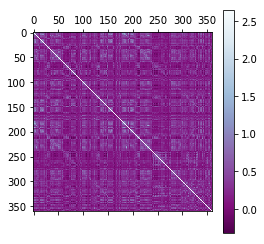

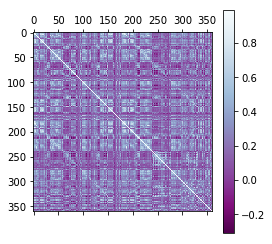

In [15]:
from nilearn.image import index_img
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt
%matplotlib inline

corr_kind = 'correlation'
subjects_tc_matrix, subname_coding = extract_mean_seris_thread(fmri_files, confound_files_merge, mmp_atlas,lmdb_filename,Trial_Num,
                                                               nr_thread=2,buffer_size=10)
print(np.array(subjects_tc_matrix).shape)
#print(subname_coding)

Subject_Num, TIME, Region_Num = np.array(subjects_tc_matrix).shape
print('Calculating functional connectivity matrix between {} Regions for {} Subjects'.format(Region_Num,Subject_Num))

print('using %s for connectivity measure...' % corr_kind)
connectome_measure = ConnectivityMeasure(kind=corr_kind)
corr_matrix = connectome_measure.fit_transform(subjects_tc_matrix)

##fisher z-transform
corr_matrix[corr_matrix >= 1.0] = 0.99   ##to avoid dividing by zero
corr_matrix[corr_matrix <= -1.0] = -0.99
corr_matrix_z = np.arctanh(corr_matrix)
mean_corr_matrix_z = np.mean(corr_matrix_z, axis=0)
#print(mean_corr_matrix_z.shape)
plt.matshow(mean_corr_matrix_z, cmap=plt.cm.BuPu_r)
plt.colorbar()

mean_corr_matrix = np.tanh(mean_corr_matrix_z)
plt.matshow(mean_corr_matrix, cmap=plt.cm.BuPu_r)
plt.colorbar()

In [30]:
fmri_file = "/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107725/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii"
mmp_atlas_roi = nib.load(mmp_atlas).get_data()
tc_roi_matrix = map_surface_to_parcel_fast(mmp_atlas_roi, fmri_file)
print(tc_roi_matrix.shape)
if tc_roi_matrix is None:
    print("Skip data loading for subject:", fmri_file)
    
data = None
if data is None or data.shape[1] != Trial_Num:
    print('no data')

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107725/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/107725/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
(360, 1200)
no data


In [ ]:
###new test of dataflow

In [9]:
from tensorpack.utils import logger
from tensorpack import dataflow
from tensorpack.utils.utils import get_tqdm
from tensorpack.utils.serialize import dumps, loads
import lmdb
def map_surface_to_parcel(atlas_roi, fmri_file):

    #atlas_roi = nib.load(parcel_map).get_data()
    #RegionLabels = np.unique(atlas_roi)
    RegionLabels = [i for i in np.unique(atlas_roi) if i != 0]

    tc_matrix = nib.load(fmri_file).get_data()
    if atlas_roi.shape[1] != tc_matrix.shape[1]:
        print("Dimension of parcellation map not matching")
        print("%d vs %d " % (atlas_roi.shape[1], tc_matrix.shape[1]))
        tc_matrix = tc_matrix[:, range(atlas_roi.shape[1])]

    tc_roi_matrix = []
    for li in sorted(RegionLabels):
        tmp_ind = [ind for ind in range(tc_matrix.shape[1]) if atlas_roi[0][ind] == li]
        tc_roi_matrix.append(np.mean(tc_matrix[:, tmp_ind], axis=1))

    ##print(np.transpose(np.array(tc_roi_matrix),(1,0)).shape)
    return tc_roi_matrix

####tensorpack: multithread
class dataflow_fmri_with_confound(dataflow.DataFlow):
    """ Iterate through fmri filenames and confound filenames
    """

    def __init__(self, fmri_files, confound_files):
        assert (len(fmri_files) == len(confound_files))
        # self.data=zip(fmri_files,confound_files)
        self.fmri_files = fmri_files
        self.confound_files = confound_files
        self._size = len(fmri_files)

    def size(self):
        return self._size

    def get_data(self):
        if isinstance(self.confound_files, pd.DataFrame):
            for a, b in zip(self.fmri_files, self.confound_files.values):
                yield a, b
        else:
            for a, b in zip(self.fmri_files, self.confound_files):
                yield a, b
            
def map_surface_to_parcel_fast(atlas_roi, fmri_file):
    ##build a dataframe to extract mean time-series for each roi within each trial

    #atlas_roi = nib.load(parcel_map).get_data()
    RegionLabels = [i for i in np.unique(atlas_roi) if i != 0]
    Region_Num = len(RegionLabels)

    tc_matrix = nib.load(str(fmri_file)).get_data()
    if atlas_roi.shape[1] != tc_matrix.shape[1]:
        print("Dimension of parcellation map not matching")
        print("%d vs %d " % (atlas_roi.shape[1], tc_matrix.shape[1]))
        tc_matrix = tc_matrix[:, range(atlas_roi.shape[1])]

    print('Read data from: ', fmri_file)
    Trial_Num, Node_Num = tc_matrix.shape
    tc_matrix_df = pd.DataFrame(data=tc_matrix.ravel(), columns=['tc_signal'])
    tc_matrix_df['roi_label'] = np.repeat(atlas_roi, Trial_Num, axis=0).ravel()
    tc_matrix_df['trial_id'] = np.repeat(np.arange(Trial_Num).reshape((Trial_Num, 1)), Node_Num, axis=1).ravel()
    # df = pd.DataFrame(values, index=index)

    tc_roi = tc_matrix_df.groupby(['roi_label', 'trial_id'], as_index=False).mean()
    tc_roi_matrix = tc_roi['tc_signal'][tc_roi['roi_label'] != 0]
    tc_roi_matrix = tc_roi_matrix.values.reshape(Region_Num, Trial_Num)

    print('Done reading fmri data ', fmri_file)
    # print(np.transpose(np.array(tc_roi_matrix),(1,0)).shape)
    return tc_roi_matrix

def map_func_extract_seris(dp, mmp_atlas_roi):
    fmri_file = dp[0]
    confound_file = dp[1]

    #tc_roi_matrix = map_surface_to_parcel(mmp_atlas_roi, fmri_file)
    tc_roi_matrix = map_surface_to_parcel_fast(mmp_atlas_roi, fmri_file)
    print('Regress out head motion from: ',confound_file)
    tc_matrix = np.transpose(np.array(tc_roi_matrix), (1, 0))
    confound = np.loadtxt(confound_file)
    ##regress out confound effects
    tc_matrix = preprocessing.scale(tc_matrix)
    regr.fit(confound, tc_matrix)
    mist_roi_tc = tc_matrix - np.matmul(confound, regr.coef_.T)

    print('Done regression of confounds ')
    return [fmri_file, mist_roi_tc]

def map_func_extract_resting(dp, mmp_atlas_roi,lowcut=0.01,highcut=0.08,TR=0.72):
    fmri_file = dp[0]
    confound_file = dp[1]
    headmove_file = confound_file[0]
    wm_file = confound_file[1]
    csf_file = confound_file[2]
    #print(len(confound_file),headmove_file,wm_file,csf_file)
    try:
        tc_roi_matrix = map_surface_to_parcel_fast(mmp_atlas_roi, fmri_file)
        print('Regress out head motion from: ',confound_file)
        tc_matrix = np.transpose(np.array(tc_roi_matrix), (1, 0))
        from sklearn import preprocessing
        confound_move = np.loadtxt(headmove_file)
        confound_wm = np.expand_dims(preprocessing.scale(np.loadtxt(wm_file)),1)
        confound_csf = np.expand_dims(preprocessing.scale(np.loadtxt(csf_file)),1)
        confound_matrix = np.hstack((confound_move, confound_wm, confound_csf))

        ###step2: regress out confound effects and save the residuals
        from nilearn import signal
        tc_matrix_clean = signal.clean(tc_matrix, detrend=True, standardize=True, confounds=confound_matrix,
                                       low_pass=highcut, high_pass=lowcut, t_r=TR)
    except:
        tc_matrix_clean = None
    print('Done regression of confounds ')
    return [fmri_file, tc_matrix_clean,confound_file]


def dump_mean_seris_to_lmdb(df, lmdb_path, write_frequency=10):
    """
    save extracted series into lmdb:lmdb_path
    """
    assert isinstance(df, dataflow.DataFlow), type(df)
    isdir = os.path.isdir(lmdb_path)
    if isdir:
        assert not os.path.isfile(os.path.join(lmdb_path, 'data.mdb')), "LMDB file exists!"
    else:
        assert not os.path.isfile(lmdb_path), "LMDB file exists!"
    df.reset_state()
    db = lmdb.open(lmdb_path, subdir=isdir,
                   map_size=int(1e12) * 2, readonly=False,
                   meminit=False, map_async=True)  # need sync() at the end
    try:
        sz = df.size()
    except NotImplementedError:
        sz = 0

    failed_list=[]
    failed_confoned_list=[]
    print(df)
    print(df.get_data())
    with get_tqdm(total=sz) as pbar:
        idx = -1
        keys = []
        txn = db.begin(write=True)
        for idx, dp in enumerate(df.get_data()):
            print(dp)
            if dp[1] is None:
                failed_list.append(dp[0])
                failed_confoned_list.append(dp[2])
            else:
                keystr = u'{}'.format(dp[0]).encode('ascii')
                txn.put(keystr, dumps(dp[1].astype('float32')))  ##change datatype to float32
                #keys += [keystr]
                pbar.update()
                print(idx, keystr)

            if (idx + 1) % write_frequency == 0:
                txn.commit()
                txn = db.begin(write=True)
                # print(idx+1)

        # write last batch
        txn.commit()

        #with db.begin(write=True) as txn:
        #    txn.put(b'__keys__', dumps(keys))

        logger.info("Flushing database ...")
        db.sync()

    db.close()
    logger.info("Closing LMDB files ...")
    
    print(failed_list,failed_confoned_list)
    return failed_list,failed_confoned_list

def extract_mean_seris_thread(fmri_files, confound_files, mmp_atlas, lmdb_filename, Trial_Num,nr_thread=100, buffer_size=50):
    ####extract roi mean time series and save to lmdb file

    buffer_size = min(len(fmri_files),buffer_size)
    nr_thread = min(len(fmri_files),nr_thread)

    if not os.path.isfile(lmdb_filename):
        mmp_atlas_roi = nib.load(mmp_atlas).get_data()
        start_time = time.clock()
        while len(fmri_files)>0:
            #print(fmri_files[:10],confound_files[:10])
            ds0 = dataflow_fmri_with_confound(fmri_files, confound_files)
            print('dataflowSize is ' + str(ds0.size()))

            #print('buffer_size is ' + str(buffer_size))
            print('Loading data using %d threads with %d buffer_size ... \n\n' % (nr_thread, buffer_size))

            ####running the model
            if any('REST' in string for string in lmdb_filename.split('_')):
                ds1 = dataflow.MultiThreadMapData(
                    ds0, nr_thread=nr_thread,
                    map_func=lambda dp: map_func_extract_resting(dp, mmp_atlas_roi,lowcut=0.01,highcut=0.08,TR=0.72),
                    buffer_size=buffer_size,
                    strict=True)
            else:
                ds1 = dataflow.MultiThreadMapData(
                    ds0, nr_thread=nr_thread,
                    map_func=lambda dp: map_func_extract_seris(dp, mmp_atlas_roi),
                    buffer_size=buffer_size,
                    strict=True)
            ds1 = dataflow.PrefetchDataZMQ(ds1, nr_proc=1)
            ##ds1._reset_once()
            ds1.reset_state()

            fmri_files,confound_files=dump_mean_seris_to_lmdb(ds1, lmdb_filename, write_frequency=buffer_size)
        print('Time Usage of loading data in seconds: {}'.format(time.clock() - start_time))

    ## read lmdb matrix
    print('loading data from file: %s' % lmdb_filename)
    matrix_dict = []
    fmri_sub_name = []
    lmdb_env = lmdb.open(lmdb_filename, subdir=False)
    try:
        lmdb_txn = lmdb_env.begin()
        listed_fmri_files = loads(lmdb_txn.get(b'__keys__'))
        listed_fmri_files = [l.decode("utf-8") for l in listed_fmri_files]
        print('Stored fmri data from files:')
        print(len(listed_fmri_files))
    except:
        print('Search each key for every fmri file...')

    with lmdb_env.begin() as lmdb_txn:
        cursor = lmdb_txn.cursor()
        for key, value in cursor:
            #print(key)
            if key == b'__keys__':
                continue
            pathsub = Path(os.path.dirname(key.decode("utf-8")))
            if any('REST' in string for string in lmdb_filename.split('_')):
                fmri_sub_name.append(pathsub.parts[-3] + '_' + pathsub.parts[-1].split('_')[-2][-1] + '_' + pathsub.parts[-1].split('_')[-1])
            else:
                fmri_sub_name.append(pathsub.parts[-3] + '_' + pathsub.parts[-1].split('_')[-1])
            data = loads(lmdb_txn.get(key))
            if data.shape[0] != Trial_Num:
                print('fmri data shape mis-matching between subjects...')
                print('Check subject:  %s with only %d Trials \n' % (fmri_sub_name[-1], data.shape[0]))
            matrix_dict.append(np.array(data))
    lmdb_env.close()

    # print(np.array(matrix_dict).shape)
    # print(fmri_sub_name)
    return matrix_dict, fmri_sub_name

In [10]:
import nibabel as nib
import pandas as pd
import time
AtlasName = 'MMP'
mmp_atlas = "/home/yuzhang/projects/rrg-pbellec/yuzhang/HCP/codes/" + "HCP_S1200_GroupAvg_v1/" + "Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii"
lmdb_filename = pathout + modality + AtlasName + '_ROI_act_1200R_test2_t100.lmdb'
print(lmdb_filename)
!rm -f /home/yuzhang/projects/rrg-pbellec/yuzhang/HCP/RESTMMP_ROI_act_1200R_test2_t100.lmdb*

tc_matrix = nib.load(fmri_files[0])
Trial_Num, Node_Num = tc_matrix.shape 
print(len(fmri_files),len(confound_files),len(WM_files),len(CSF_files))
confound_files_merge = pd.DataFrame(list(zip(confound_files, WM_files, CSF_files)), 
                                    columns=['headmove', 'wm', 'csf'])
print((confound_files_merge).shape)

subjects_tc_matrix, subname_coding = extract_mean_seris_thread(fmri_files, confound_files_merge, mmp_atlas,lmdb_filename,Trial_Num,
                                                       nr_thread=2,buffer_size=10)


/home/yuzhang/projects/rrg-pbellec/yuzhang/HCP/RESTMMP_ROI_act_1200R_test2_t100.lmdb
PrefetchDataZMQ successfully cleaned-up.


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


376 376 376 376
(376, 3)


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii', '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii', '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii', '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii', '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii', '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii', '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii', '/home/yuzhang/proj

  0%|          |0/376[00:00<?,?it/s]

<generator object PrefetchDataZMQ.get_data at 0x2b25e4811ba0>


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST1_LR/rfMRI_REST1_

ValueError: Cannot create an object array from a string

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


59412 vs 91282 
Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbe

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_c

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/10040

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
 ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']Regress out head motion from: Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST2_RL/rfMRI_REST2_

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


59412 vs 91282 
Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbe

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_c

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_c

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
Dimension of parcellation map not matching
59412 vs 91282 
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 
Don

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_c

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101410/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101410/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101410/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101410/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101410/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101410/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/10141

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/10191

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DAT

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done regression of confounds 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii

Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102311/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102513/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102614/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102715/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102816/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103010/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103111/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103212/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103414/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103515/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/103818/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104012/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104416/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/104820/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105014/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii

Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii

Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105115/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105216/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST1_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST1_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST1_RL/rfMRI_REST1_RL_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST2_LR/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST2_LR/rfMRI_REST2_LR_CSF.txt']
Done regression of confounds 


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST2_RL/Movement_Regressors.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_WM.txt'
 '/home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105620/FMRI/rfMRI_REST2_RL/rfMRI_REST2_RL_CSF.txt']
Done regression of confounds 
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/105923/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Regress out head motion from:  ['/home/yuzhang/projects

In [10]:
from nilearn.image import index_img
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt
%matplotlib inline


subjects_tc_matrix, subname_coding = extract_mean_seris_thread(fmri_files, confound_files_merge, mmp_atlas,lmdb_filename,Trial_Num,
                                                               nr_thread=2,buffer_size=10)
print(np.array(subjects_tc_matrix).shape)
#print(subname_coding)

Subject_Num, TIME, Region_Num = np.array(subjects_tc_matrix).shape
print('Calculating functional connectivity matrix between {} Regions for {} Subjects'.format(Region_Num,Subject_Num))

print('using %s for connectivity measure...' % corr_kind)
connectome_measure = ConnectivityMeasure(kind=corr_kind)
corr_matrix = connectome_measure.fit_transform(subjects_tc_matrix)

##fisher z-transform
corr_matrix[corr_matrix >= 1.0] = 0.99   ##to avoid dividing by zero
corr_matrix[corr_matrix <= -1.0] = -0.99
corr_matrix_z = np.arctanh(corr_matrix)
mean_corr_matrix_z = np.mean(corr_matrix_z, axis=0)
#print(mean_corr_matrix_z.shape)
plt.matshow(mean_corr_matrix_z, cmap=plt.cm.BuPu_r)
plt.colorbar()

mean_corr_matrix = np.tanh(mean_corr_matrix_z)
plt.matshow(mean_corr_matrix, cmap=plt.cm.BuPu_r)
plt.colorbar()

loading data from file: /home/yuzhang/projects/rrg-pbellec/yuzhang/HCP/RESTMMP_ROI_act_1200R_test_t100.lmdb
Search each key for every fmri file...
(0,)
PrefetchDataZMQ successfully cleaned-up.


ValueError: not enough values to unpack (expected 3, got 1)

(1200, 12) (1200, 1) (1200, 1)
(1200, 14)
(1200, 360)


/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


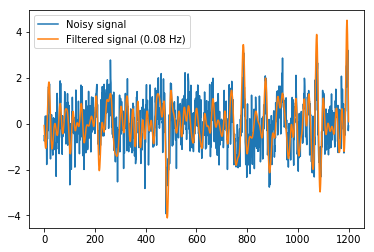

In [67]:
from nilearn import signal
import pandas as pd
confound_move = np.loadtxt(confound_file)
confound_wm = np.expand_dims(np.loadtxt(wm_file),1)
confound_csf = np.expand_dims(np.loadtxt(csf_file),1)
print(confound_move.shape,confound_wm.shape,confound_csf.shape)

confound_matrix = np.hstack((confound_move,confound_wm,confound_csf ))
print(confound_matrix.shape)

y=signal.clean(np.transpose(np.array(tc_roi_matrix)), detrend=True, standardize=True, confounds=confound_matrix,
               low_pass=highcut, high_pass=lowcut, t_r=TR)
print(y.shape)
plt.figure(2)
plt.clf()
t = np.linspace(0, 1200)
x = preprocessing.scale(np.transpose(np.array(tc_roi_matrix))[:,100])
y = preprocessing.scale(y[:,100])
plt.plot(x, label='Noisy signal')
plt.plot(y, label='Filtered signal (%g Hz)' % highcut)
plt.legend(loc='best')

(-0.1, 0.1)

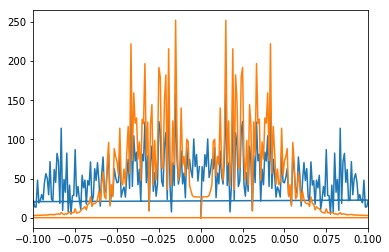

In [70]:
import numpy.fft as fft
data = y
spectrum = fft.fft(data)
freq = fft.fftfreq(len(spectrum))
plt.figure()
plt.plot(freq,abs(fft.fft(x)))
plt.plot(freq, abs(fft.fft(y)))
plt.xlim((-0.1, 0.1))

In [45]:
###load rs-fMRI signals
import nibabel as nib
import numpy as np
import os
import h5py
import pandas as pd
from nilearn import signal
from sklearn import linear_model
from sklearn import preprocessing
regr = linear_model.LinearRegression()

mmp_atlas = "/home/yuzhang/projects/rrg-pbellec/yuzhang/HCP/codes/HCP_S1200_GroupAvg_v1/Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii"
mmp_atlas_roi = nib.load(mmp_atlas).get_data()
Region_Num = len(np.unique(mmp_atlas_roi))
Region_Labels = np.unique(mmp_atlas_roi)
print("%d regions in the parcellation map" % Region_Num)

Subject_Num = 10
TR = 0.72
lowcut = 0.01
highcut = 0.08

subjects_tc_matrix = []
sub_name = []
session_id = []
coding_direct = []
for fmri_file, confound_file, wm_file, csf_file, sub_count in zip(fmri_files, confound_files,WM_files,CSF_files,range(Subject_Num)):
    pathsub = Path(os.path.dirname(fmri_files[sub_count]))
    if os.path.dirname(fmri_file) != os.path.dirname(str(confound_file)):
        print('Mis-matching subject between fmri data %s and confounding files %s ' %
              (Path(os.path.dirname(fmri_file)).parts[-3], Path(os.path.dirname(confound_file)).parts[-3]))
    if os.path.dirname(fmri_file) != os.path.dirname(str(wm_file)):
        print('Mis-matching subject between fmri data %s and confounding files %s ' %
              (Path(os.path.dirname(fmri_file)).parts[-3], Path(os.path.dirname(confound_file)).parts[-3]))
    if os.path.dirname(fmri_file) != os.path.dirname(str(csf_file)):
        print('Mis-matching subject between fmri data %s and confounding files %s ' %
              (Path(os.path.dirname(fmri_file)).parts[-3], Path(os.path.dirname(confound_file)).parts[-3]))
    sub_name.append(pathsub.parts[-3])
    session_id.append(pathsub.parts[-1].split('_')[-2][-1])
    coding_direct.append(pathsub.parts[-1].split('_')[-1])

    ##step1:load fmri time-series and confounds into matrix
    mmp_atlas_roi = nib.load(mmp_atlas).get_data()
    tc_roi_matrix = map_surface_to_parcel_fast(mmp_atlas_roi, fmri_file)
    tc_matrix = np.transpose(np.array(tc_roi_matrix), (1, 0))
    if confound_file == '':
        confound_move = np.ones((tc_matrix.shape[0],), dtype=int)
    else:
        confound_move = np.loadtxt(confound_file)
    if wm_file == '':
        confound_wm = np.ones((tc_matrix.shape[0],), dtype=int)
    else:
        confound_wm = np.expand_dims(np.loadtxt(wm_file),1)
    if csf_file == '':
        confound_csf = np.ones((tc_matrix.shape[0],), dtype=int)
    else:
        confound_csf = np.expand_dims(np.loadtxt(csf_file),1)
    confound_matrix = np.hstack((confound_move, confound_wm, confound_csf))

    ###step2: regress out confound effects and save the residuals
    from nilearn import signal
    tc_matrix_clean = signal.clean(tc_matrix, detrend=True, standardize=True, confounds=confound_matrix,
                                   low_pass=highcut, high_pass=lowcut, t_r=TR)
    subjects_tc_matrix.append((tc_matrix_clean)) ##np.transpose
    if divmod(sub_count, 100)[1] == 0:
        print("Processing subjects: %d" % sub_count)

print(np.array(subjects_tc_matrix).shape)

tcs_all_subjects_file = pathout + modality + "_timecourse_360ROIs.h5" 
hdf5 = h5py.File(tcs_all_subjects_file, 'w')
g1 = hdf5.create_group('region_tc')
# g1.create_dataset('subjects',data=np.array(subjects_tc_matrix),compression="gzip")
for subj in range(Subject_Num):
    g1.create_dataset('subj' + str(subj + 1), data=subjects_tc_matrix[subj], compression="gzip")
g2 = hdf5.create_group('sub_info')
g2.create_dataset('sub_name', data=np.array(sub_name).astype('|S9'), compression="gzip")
g2.create_dataset('session', data=np.array(session_id).astype('|S9'), compression="gzip")
g2.create_dataset('coding', data=np.array(coding_direct).astype('|S9'), compression="gzip")
hdf5.close()  # closes the file


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


360 regions in the parcellation map


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100307/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Processing subjects: 0


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100408/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/100610/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101006/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101107/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101309/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101410/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101410/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/101915/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102008/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Dimension of parcellation map not matching
59412 vs 91282 
Read data from:  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
Done reading fmri data  /home/yuzhang/projects/rrg-pbellec/DATA/HCP/aws-s3_copy_022718/102109/FMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_hp2000_clean.dtseries.nii
(10, 1200, 360)


In [47]:
###loading time-series data from files
'''
subjects_tc_matrix = np.loadtxt(tcs_all_subjects_file).reshape((Subject_Num, Trial_Num, Region_Num))
'''
hdf = h5py.File(tcs_all_subjects_file, 'r')
group1 = hdf.get('region_tc')
group2 = hdf.get('sub_info')

subjects_tc_matrix = []
for subj in range(Subject_Num):
    n1 = np.array(group1.get('subj' + str(subj + 1)))
    subjects_tc_matrix.append(n1)
sub_name = [sub.decode("utf-8") for sub in np.array(group2.get('sub_name'))]
session_id = [sub.decode("utf-8") for sub in np.array(group2.get('session'))]
coding_direct = [sub.decode("utf-8") for sub in np.array(group2.get('coding'))]
hdf.close()
print(np.array(subjects_tc_matrix).shape)

(10, 1200, 360)


In [53]:
from nilearn.connectome import ConnectivityMeasure
corr_kind = 'correlation'
corr_all_subjects_file = pathout + modality + "_RSFC_360ROIs.h5"

Subject_Num, TIME, Region_Num = np.array(subjects_tc_matrix).shape
print('Calculating functional connectivity matrix between {} Regions for {} Subjects'.format(Region_Num,Subject_Num))

print('using %s for connectivity measure...' % corr_kind)
connectome_measure = ConnectivityMeasure(kind=corr_kind)
corr_matrix = connectome_measure.fit_transform(subjects_tc_matrix)

##fisher z-transform
corr_matrix_z = np.arctanh(corr_matrix)
mean_corr_matrix_z = np.mean(corr_matrix_z, axis=0)
#print(mean_corr_matrix_z.shape)
#plt.matshow(mean_corr_matrix_z, cmap=plt.cm.BuPu_r)
#plt.colorbar()

mean_corr_matrix = np.tanh(mean_corr_matrix_z)
#plt.matshow(mean_corr_matrix, cmap=plt.cm.BuPu_r)
#plt.colorbar()

print(corr_matrix.shape)
hdf5.close()  # closes the file
hdf5 = h5py.File(corr_all_subjects_file, 'w')

g1 = hdf5.create_group('FC_corr_mat')
g1.create_dataset('mean_corr_mat', data=np.array(mean_corr_matrix), compression="gzip")
for subj in range(Subject_Num):
    g1.create_dataset('subj' + str(subj + 1), data=corr_matrix[subj], compression="gzip")

g2 = hdf5.create_group('FC_corr_mat_z')
g2.create_dataset('mean_corr_mat_z', data=np.array(mean_corr_matrix_z), compression="gzip")
for subj in range(Subject_Num):
    g2.create_dataset('subj' + str(subj + 1), data=corr_matrix_z[subj], compression="gzip")
g3 = hdf5.create_group('sub_info')
g3.create_dataset('sub_name', data=np.array(sub_name).astype('|S9'), compression="gzip")
g3.create_dataset('session', data=np.array(session_id).astype('|S9'), compression="gzip")
g3.create_dataset('coding', data=np.array(coding_direct).astype('|S9'), compression="gzip")
hdf5.close()  # closes the file


Calculating functional connectivity matrix between 360 Regions for 10 Subjects
using correlation for connectivity measure...


/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in arctanh
  del sys.path[0]


(10, 360, 360)


In [70]:
print(corr_all_subjects_file.split('.')[0]+'.lmdb')

/home/yuzhang/projects/rrg-pbellec/yuzhang/HCP/rfMRI_REST1_LR_RSFC_360ROIs.lmdb


(10, 360, 360)
10
(360, 360)
(360, 360)


/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,1,'group average conn-matrix')

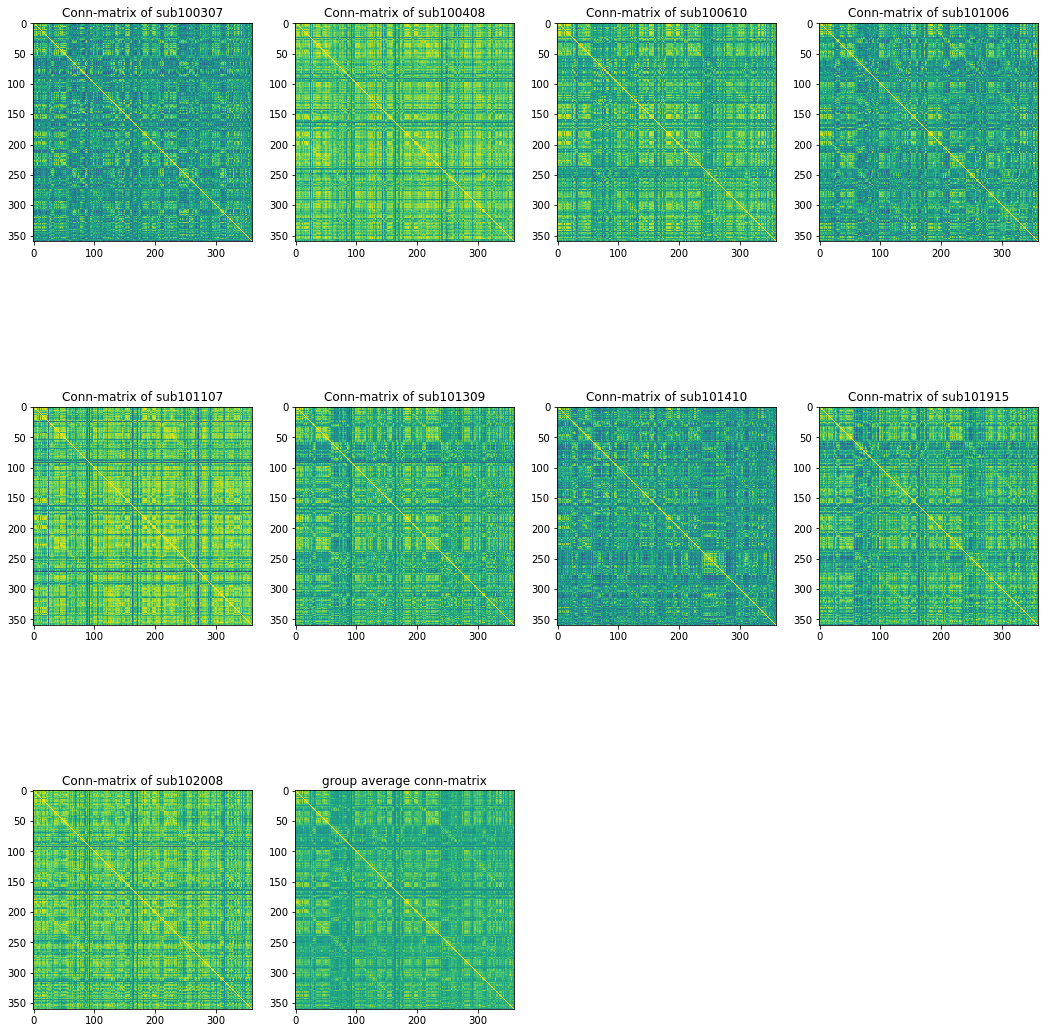

In [67]:
###loading RSFC data from files
#hdf.close()
hdf = h5py.File(corr_all_subjects_file, 'r')
group1 = hdf.get('FC_corr_mat')
group2 = hdf.get('FC_corr_mat_z')
group3 = hdf.get('sub_info')

mean_corr_matrix = np.array(group1.get('mean_corr_mat'))
mean_corr_matrix_z = np.array(group2.get('mean_corr_mat_z'))
corr_matrix = []
corr_matrix_z = []
for subj in range(Subject_Num):
    n1 = np.array(group1.get('subj' + str(subj + 1)))
    corr_matrix.append(n1)

    n2 = np.array(group2.get('subj' + str(subj + 1)))
    corr_matrix_z.append(n2)
sub_name = [sub.decode("utf-8") for sub in np.array(group3.get('sub_name'))]
session_id = [sub.decode("utf-8") for sub in np.array(group3.get('session'))]
coding_direct = [sub.decode("utf-8") for sub in np.array(group3.get('coding'))]
hdf.close()
print(np.array(corr_matrix).shape)

import matplotlib.pyplot as plt
%matplotlib inline

print(len(corr_matrix))
print(np.mean(corr_matrix,axis=0).shape)
print(corr_matrix[ii].shape)

plt.figure(figsize=(18, 20))
for ii in range(len(corr_matrix)):
    plt.subplot(3,4,ii+1)
    plt.imshow(corr_matrix[ii],vmin=-1, vmax=1);
    plt.title('Conn-matrix of sub' + sub_name[ii])
plt.subplot(3,4,ii+1)
plt.imshow(np.mean(corr_matrix,axis=0),vmin=-1, vmax=1)
plt.title('group average conn-matrix')
##plt.colorbar()

In [4]:
sub_name = []
session_id = []
coding_direct = []
for fmri_file, confound_file, wm_file, csf_file, sub_count in zip(fmri_files, confound_files,WM_files,CSF_files,range(Subject_Num)):
    pathsub = Path(os.path.dirname(fmri_files[sub_count]))
    #print(fmri_file,confound_file,wm_file,csf_file)
    if os.path.dirname(fmri_file) != os.path.dirname(str(confound_file)):
        print('Mis-matching subject between fmri data %s and confounding files %s ' % 
              (Path(os.path.dirname(fmri_file)).parts[-3], Path(os.path.dirname(confound_file)).parts[-3]))
    if os.path.dirname(fmri_file) != os.path.dirname(str(wm_file)):
        print('Mis-matching subject between fmri data %s and confounding files %s ' % 
              (Path(os.path.dirname(fmri_file)).parts[-3], Path(os.path.dirname(confound_file)).parts[-3]))
    if os.path.dirname(fmri_file) != os.path.dirname(str(csf_file)):
        print('Mis-matching subject between fmri data %s and confounding files %s ' % 
              (Path(os.path.dirname(fmri_file)).parts[-3], Path(os.path.dirname(confound_file)).parts[-3]))
    sub_name.append(pathsub.parts[-3])
    session_id.append(pathsub.parts[-1].split('_')[-2][-1])
    coding_direct.append(pathsub.parts[-1].split('_')[-1])

print(sub_name, session_id, coding_direct)

['100206', '100307', '100408', '100610', '101006', '101107', '101309', '101410', '101915', '102008'] ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1'] ['LR', 'LR', 'LR', 'LR', 'LR', 'LR', 'LR', 'LR', 'LR', 'LR']


(1200, 360)


/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/sklearn/neighbors/approximate.py:220: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


(360, 360)
(360, 360)
(360, 360)


/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/numpy/linalg/linalg.py:1817: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/numpy/linalg/linalg.py:1817: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


(360, 360)


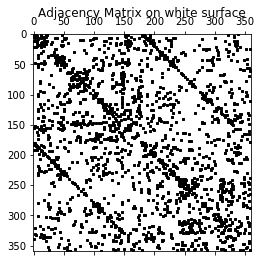

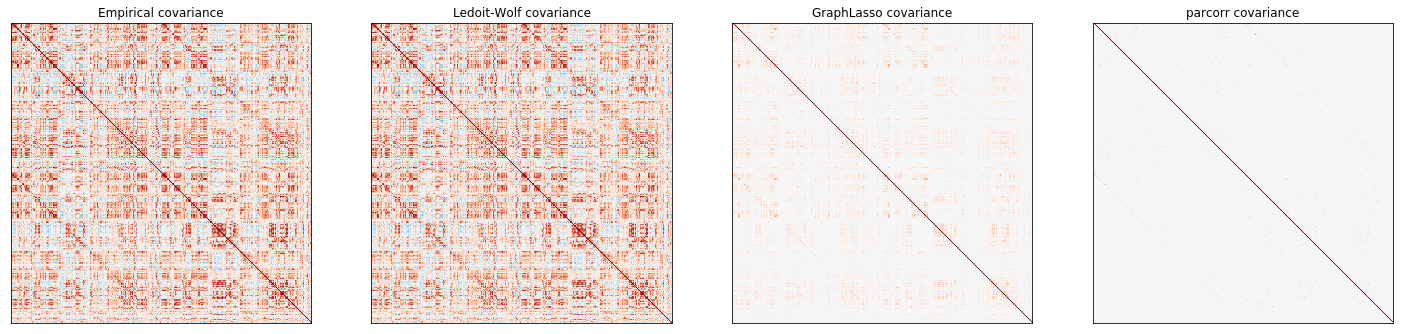

In [16]:
###calculate functional connectivity matrix
#from cnn_graph.lib import models, graph, coarsening, utils
from scipy import sparse
from sklearn.covariance import GraphLassoCV, ledoit_wolf
import matplotlib.pyplot as plt
%matplotlib inline

conn_roi_matrix = np.transpose(subjects_tc_matrix[1])
print(conn_roi_matrix.shape)

def distance_lshforest(z, k=4, metric='cosine'):
    """Return an approximation of the k-nearest cosine distances."""
    from sklearn import neighbors
    lshf = neighbors.LSHForest()
    lshf.fit(z)
    dist, idx = lshf.kneighbors(z, n_neighbors=k+1)
    assert dist.min() < 1e-10
    dist[dist < 0] = 0
    return dist, idx

def adjacency(dist, idx):
    """Return the adjacency matrix of a kNN graph."""
    from scipy import sparse
    M, k = dist.shape
    assert M, k == idx.shape
    assert dist.min() >= 0

    # Weights.
    sigma2 = np.mean(dist[:, -1])**2
    dist = np.exp(- dist**2 / sigma2)

    # Weight matrix.
    I = np.arange(0, M).repeat(k)
    J = idx.reshape(M*k)
    V = dist.reshape(M*k)
    W = sparse.coo_matrix((V, (I, J)), shape=(M, M))

    # No self-connections.
    W.setdiag(0)

    # Non-directed graph.
    bigger = W.T > W
    W = W - W.multiply(bigger) + W.T.multiply(bigger)

    assert W.nnz % 2 == 0
    assert np.abs(W - W.T).mean() < 1e-10
    assert type(W) is sparse.csr.csr_matrix
    return W

###using cosine from gcnn package
dist, idx = distance_lshforest(np.transpose(conn_roi_matrix), k=4, metric='cosine')
adj_mat = adjacency(dist, idx)

print(adj_mat.shape)
#A = graph.replace_random_edges(adj_mat, noise_level)
plt.figure()
plt.spy(adj_mat, markersize=2, color='black');
plt.title("Adjacency Matrix on white surface")

###covaraince matrix
emp_cov = np.cov(np.transpose(conn_roi_matrix))
print(emp_cov.shape)

lw_cov_, _ = ledoit_wolf(conn_roi_matrix)
print(lw_cov_.shape)

##covaraince and partial correlations
sparse_cov = GraphLassoCV().fit(conn_roi_matrix)
cov_ = sparse_cov.covariance_
parcorr_ = sparse_cov.precision_ 
print(cov_.shape)


plt.figure(figsize=(20, 12))
plt.subplots_adjust(left=0.02, right=0.98)

# plot the covariances
covs = [('Empirical', emp_cov), ('Ledoit-Wolf', lw_cov_),
        ('GraphLasso', cov_), ('parcorr', parcorr_)]
vmax = cov_.max()
for i, (name, this_cov) in enumerate(covs):
    plt.subplot(1, 4, i + 1)
    plt.imshow(this_cov, interpolation='nearest', vmin=-vmax, vmax=vmax,
               cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.title('%s covariance' % name)

(1200, 360)
(1200, 360)
(360, 360)


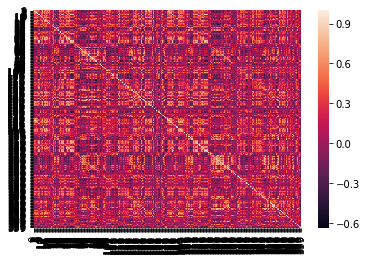

In [5]:
from scipy import sparse
from sklearn.covariance import GraphLassoCV, ledoit_wolf
import matplotlib.pyplot as plt
%matplotlib inline

conn_roi_matrix = np.transpose(subjects_tc_matrix[1])
print(conn_roi_matrix.shape)

roi_tc_df = pd.DataFrame(data=(conn_roi_matrix))
print(roi_tc_df.shape)

import seaborn as sns
corr = roi_tc_df.corr()
print(corr.shape)
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

(360, 360)


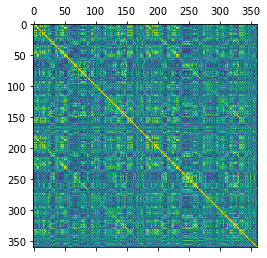

In [21]:
print(corr.shape)
plt.matshow(corr)

(1, 360, 360)
(10, 360, 360)
[[1.         0.46587157 0.63461363 ... 0.34429887 0.45209008 0.42252356]
 [0.46587157 1.         0.66098785 ... 0.38194734 0.21280241 0.19680908]
 [0.63461363 0.66098785 1.         ... 0.37843078 0.23020823 0.18080267]
 ...
 [0.34429887 0.38194734 0.37843072 ... 1.         0.2549723  0.22929236]
 [0.45209008 0.21280241 0.23020823 ... 0.2549723  1.         0.56403226]
 [0.42252356 0.19680908 0.18080266 ... 0.22929236 0.56403226 1.        ]]


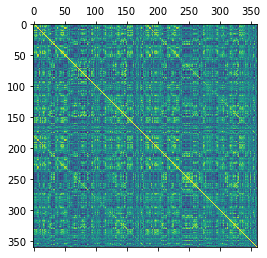

In [14]:
from nilearn.connectome import ConnectivityMeasure

correlations = []
# Initializing ConnectivityMeasure object with kind='correlation'
connectome_measure = ConnectivityMeasure(kind='correlation')
correlation = connectome_measure.fit_transform([conn_roi_matrix])
print(correlation.shape)
plt.matshow(correlation[0])

subjects_tc_matrix_T = []
for i in range(len(subjects_tc_matrix)):
    subjects_tc_matrix_T.append(np.transpose(subjects_tc_matrix[i]))
correlation_matrices = connectome_measure.fit_transform(subjects_tc_matrix_T)
print(correlation_matrices.shape)
print(connectome_measure.mean_)

/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in arctanh
  """Entry point for launching an IPython kernel.


(10, 360, 360)
(360, 360)


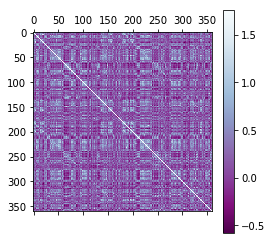

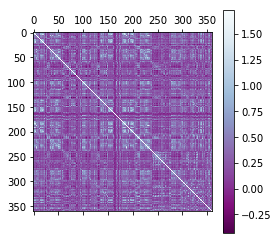

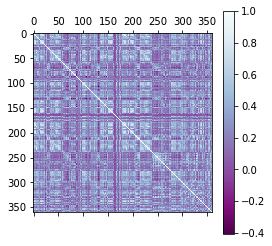

In [20]:
corr_matrix_z = np.arctanh(correlation_matrices)
print(corr_matrix_z.shape)
plt.matshow(corr_matrix_z[0],cmap=plt.cm.BuPu_r)
plt.colorbar()

mean_corr_matrix_z = np.mean(corr_matrix_z,axis=0)
print(mean_corr_matrix_z.shape)
plt.matshow(mean_corr_matrix_z,cmap=plt.cm.BuPu_r)
plt.colorbar()

mean_corr_matrix = np.tanh(mean_corr_matrix_z)
plt.matshow(mean_corr_matrix,cmap=plt.cm.BuPu_r)
plt.colorbar()

(1, 360, 360)


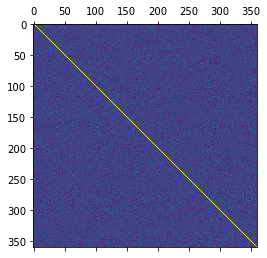

In [8]:
connectome_measure = ConnectivityMeasure(kind='partial correlation')
correlation = connectome_measure.fit_transform([conn_roi_matrix])
print(correlation.shape)
plt.matshow(correlation[0])